# Install and import dependences

In [ ]:
#!pip install --upgrade python-binance tensorflow

In [1]:
from binance.client import Client
from binance import BinanceSocketManager
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, confusion_matrix

# Load data

In [2]:
api_key = "imuSkmeAI4PpxNERZRcnzx6nEkReEhuLedZphxZNphhnUPLR4QH61aXfjnBqUtfH"
api_secret = "56AvdFdOWWoRF20rh6Knq8awDYM145luMDH0XvDMkSD6nffbRwYTCrsxwJmyVLK1"
client = Client(api_key, api_secret)

In [3]:
#Get the exchange info, which contains information about all trading pairs
exchange_info = client.get_exchange_info()

#Extract the symbols of all trading pairs
symbols = [symbol['symbol'] for symbol in exchange_info['symbols'] if "BRL" in symbol['symbol']]

#Filter out only the base cryptocurrencies (e.g., BTC, ETH)
symbols = list(symbol.split(' ')[0] for symbol in symbols)

In [4]:
# Function to fetch historical cryptocurrency data
def fetch_binance_cryptocurrency_data(symbol, start_date, end_date, interval='1d'):
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)

    # Convert data to a Pandas DataFrame
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')  # Convert timestamp to datetime

    return df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

database = {}
present_day = dt.date.today()
start_date = '1900-01-01'
end_date = f"{present_day}"
for ticker in symbols:
    data = fetch_binance_cryptocurrency_data(ticker, start_date, end_date)
    database[ticker] = data.close.values.astype(float)

In [ ]:
# Save data to CSV
for ticker, data in database.items():
    filename = f"{ticker}_data.csv"
    data.to_csv(filename, index=False)
    print(f"Data saved to {filename}")

# Model Functions

In [5]:
def model_1(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(16, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [6]:
def model_2(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(12, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [7]:
def model_3(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(8, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [8]:
def model_4(price: list, look_back: int = 11, epochs: int = 500, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(4, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

In [29]:
def model_5(price: list, look_back: int = 11, epochs: int = 100, ticker: str = None, plot_graph: bool = True):
    # Prepare data
    X = []
    y = []
    for i in range(len(price) - look_back):
        X.append(price[i:i+look_back])
        y.append(price[i+look_back])
    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)
  
    # Split data
    size = len(X)-2
    X_train, X_test = X[:size], X[size:]
    y_train, y_test = y[:size], y[size:]
    
    # Create & train model
    model = Sequential([
        SimpleRNN(11, activation='relu', input_shape=(look_back, 1), return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)
    
    # Predict & evaluate
    pred = model.predict(X_test, verbose=0)
    loss = model.evaluate(X_test, y_test, verbose=0)
    #print('Loss:', loss)
    
    '''
    X_test = y[-look_back:]
    pred1 = model.predict(X_test.reshape(1,look_back,1))
    new_x_test = pred1[0][0]
    X_test = np.append(X_test,new_x_test)
    pred2 = model.predict(X_test[-look_back:].reshape(1,look_back,1))
    '''
    
    # Set desired variables
    last_price = y_train[-1]
    pred1 = pred[0][0]
    pred2 = pred[1][0]
    status = y_train[-1] < pred1 <= pred2 or (y_train[-1] < pred2 < pred1 and (pred1-pred2) <= pred1*0.0025) or (pred1 < y_train[-1] < pred2 and (y_train[-1]-pred1) <= pred1*0.0025)
    true_price1, true_price2 = y_test[0], y_test[1]
    
    if plot_graph:
        # Plot dataset + predictions
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.plot(np.append(y_train, y_test), label='True Price')
        ax1.plot(np.arange(len(y_train), len(y_train) + len(pred)), pred, label='Predictions')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.set_title(f'{ticker} Stock Price Prediction')
        ax1.legend()

        ax2.plot(np.append(y_train[-1], y_test), label='True Price')
        ax2.plot(np.arange(len(y_test) - 1, len(y_test) + 1), pred, label='Predictions')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Price')
        ax2.set_title(f'{ticker} Stock Price Prediction')
        ax2.legend()

        plt.tight_layout()
        plt.show()
    
    return status, last_price, pred1, pred2, true_price1, true_price2, loss

# Other Functions

In [23]:
# Suppress the warning related to TensorFlow tracing
tf.autograph.set_verbosity(0)

def pred_eval(model_function, lb_list: list = [11], epochs: int = 100, ticker_list: list = symbols, print_info: bool = True):
    buy_list = []
    total_loss = 0
    total_sold = 0
    for lb in lb_list:
        pred_status_list, true_status_list = [], []
        last_price_list = []
        pred_1_list, pred_2_list = [], []
        count = 0
        total_last_stock_price, total_gamble_stock_price = 0, 0
        total_pred_stock_price, total_true_stock_price = 0, 0
        total_proft = 0

        for ticker in ticker_list:
            count += 1
            price = database[ticker]
            act_status, last_price, pred1, pred2, true_price1, true_price2, loss = model_function(price, look_back = lb, epochs=epochs, ticker=ticker, plot_graph = False)
            
            pred_status_list.append(act_status)
            last_price_list.append(last_price)
            pred_1_list.append(pred1)
            pred_2_list.append(pred2)
            total_loss += loss

            my_act_status = act_status
            my_gamble = sell_price(last_price, pred1, pred2)
            gamble_proft = my_gamble/last_price
            sold_status = check_sold(my_gamble, true_price1)

            if my_gamble/last_price < 1.001 and my_act_status == True: 
                my_act_status = False
            if my_act_status == False: 
                sold_status = None
                gamble_proft = None
            if sold_status:
                total_sold += 1
            

            if print_info:
                print('{:<2} '.format(count), 
                      '{:<8} -'.format(ticker), 
                      'LastPrice: {:<10}'.format(round(float(last_price), 3)), 
                      '/ Pred1: {:<10}'.format(round(float(pred1), 3)), 
                      '/ Pred2: {:<10}'.format(round(float(pred2), 3)), 
                      '/ TruePrice1: {:<10}'.format(round(float(true_price1), 3)), 
                      '/ TruePrice2: {:<10}'.format(round(float(true_price2), 3)), 
                      '|| ActStatus: {:<1}'.format(act_status), 
                      '/ MyActStatus: {:<1}'.format(my_act_status), 
                      '/ SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''), 
                      '/ MyGamble: {:<10}'.format(round(float(my_gamble), 3)), 
                      '/ GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                      '/ TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                      '|| CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0)))
                            

            true_proft = true_price1 - last_price
            if act_status:
                total_last_stock_price += last_price
                total_pred_stock_price += pred1
                total_gamble_stock_price += my_gamble
                total_true_stock_price += true_price1
            if true_proft > 0:
                true_status_list.append(True)
            if true_proft <= 0:
                true_status_list.append(False)
                
            if act_status and my_act_status:
                buy = ['{:<8}'.format(ticker), 
                       'LastPrice: {:<11}'.format(round(float(last_price), 5)), 
                       'MyGamble: {:<11}'.format(round(float(my_gamble), 5)), 
                       'TruePrice: {:<11}'.format(round(float(true_price1), 5)),
                       'GambleProft: {:<5}'.format(round(float(gamble_proft), 3) if gamble_proft is not None else ''), 
                       'TrueProft: {:<5}'.format(round(true_price1/last_price, 3) if gamble_proft is not None else ''),
                       'SoldStatus: {:<1}'.format(sold_status if sold_status is not None else ''),
                       'CorrectModel: {:<1}'.format(act_status == ((true_price1 - last_price) > 0))]
                buy_list.append(buy)
                      

        if not total_last_stock_price == 0:
            print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
            print('Gamble proft %:', total_gamble_stock_price / total_last_stock_price)
            print('True proft %:', total_true_stock_price / total_last_stock_price)
        if total_last_stock_price == 0:
            print('\nAll False')

        print('\nLook Back:', lb, '/ Total Loss:', total_loss, '/ Sold Portion:', total_sold/len(buy_list), '\n')
        
        for i in buy_list:
            print(i)
    
        index = my_confusion_matrix(true_status_list, pred_status_list)
        if len(index) > 0: 
            print('Wrong Buy_Act List:')
            for i in index:
                print(symbols[i], '\n')

In [10]:
def my_confusion_matrix(true_status: list, pred_status: list):
    cm = confusion_matrix(true_status, pred_status)
    labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
    cm = cm.reshape((2, 2))
    
    # Print indices where true and pred statuses are False and True respectively
    false_true_indices = []
    for i in range(len(true_status)):
        if true_status[i] == False and pred_status[i] == True:
            false_true_indices.append(i)
    
    # Calculate accuracy
    accuracy = (cm[0,0] + cm[1,1]) / np.sum(cm)
    print("CM accuracy:", accuracy)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font size
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    return false_true_indices 

In [15]:
def sell_price(last_value, pred1, pred2, margin = 0.001):
    'Optmize the sell price'
    if pred1 <= last_value and abs(last_value - pred1) <= (pred1*0.0025):
        return last_value
    
    if (pred1 - (pred1*margin)) <= last_value:
        return last_value
    
    if pred2/pred1 >= 1.05:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 + (pred1 * margin) <= last_value * 1.02:
            return pred1 + (pred1 * margin)
        else:
            return last_value * 1.02
    
    if pred2/pred1 >= 1.01:
        if pred1/last_value > 1.02:
            return last_value * 1.02
        if pred1 <= last_value * 1.02:
            return pred1
        else: 
            return last_value * 1.02

    else:
        return pred1 - (pred1 * margin)

In [12]:
def check_sold(gamble, true_price, margin = 0.002):
    'Check if the gamble price was sold'
    return gamble <= true_price + (true_price * margin)

# Predictions & Evaluate


Pred proft %: 1.014683085779911
Gamble proft %: 1.0146681162462239
True proft %: 1.0070746514452942

Look Back: 11 / Total Loss: 19857217.2563574 / Sold Portion: 0.5714285714285714 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19841.09961', 'TruePrice: 19691.93   ', 'GambleProft: 1.015', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.68446    ', 'TruePrice: 5.827      ', 'GambleProft: 1.003', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 67.57      ', 'MyGamble: 68.61662   ', 'TruePrice: 69.73      ', 'GambleProft: 1.015', 'TrueProft: 1.032', 'SoldStatus: 1', 'CorrectModel: 1']
['FISBRL  ', 'LastPrice: 1.682      ', 'MyGamble: 1.70987    ', 'TruePrice: 1.794      ', 'GambleProft: 1.017', 'TrueProft: 1.067', 'SoldStatus: 1', 'CorrectModel: 1']
['AVAXBRL ', 'LastPrice: 214.7      ', 'MyGamble: 220.30185  ', 'TruePrice: 217.2      ', 'GambleProft: 1.026', 'TrueProft: 1.012', 'SoldStatus:

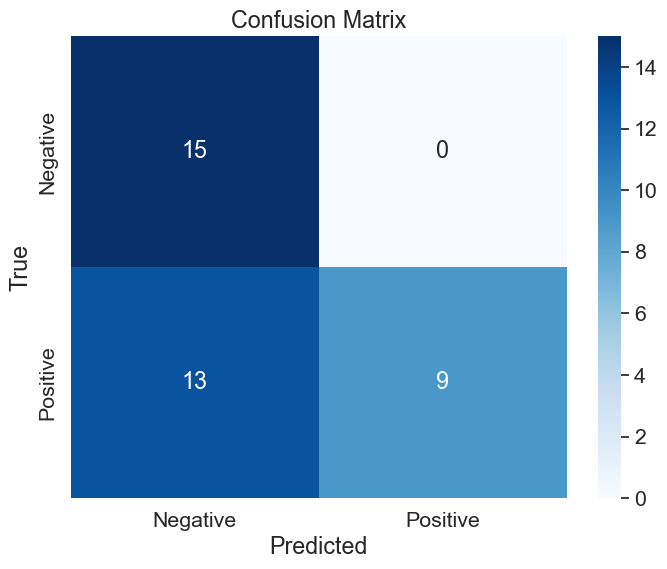


Pred proft %: 0.9982105664432616
Gamble proft %: 1.000342187510133
True proft %: 1.0065966098069579

Look Back: 11 / Total Loss: 21192274.478255197 / Sold Portion: 0.2857142857142857 

['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.16693    ', 'TruePrice: 3.125      ', 'GambleProft: 1.014', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.93987  ', 'TruePrice: 100.73     ', 'GambleProft: 1.018', 'TrueProft: 1.016', 'SoldStatus: 0', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.78011    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.01 ', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0394     ', 'MyGamble: 0.0416     ', 'TruePrice: 0.0386     ', 'GambleProft: 1.056', 'TrueProft: 0.98 ', 'SoldStatu

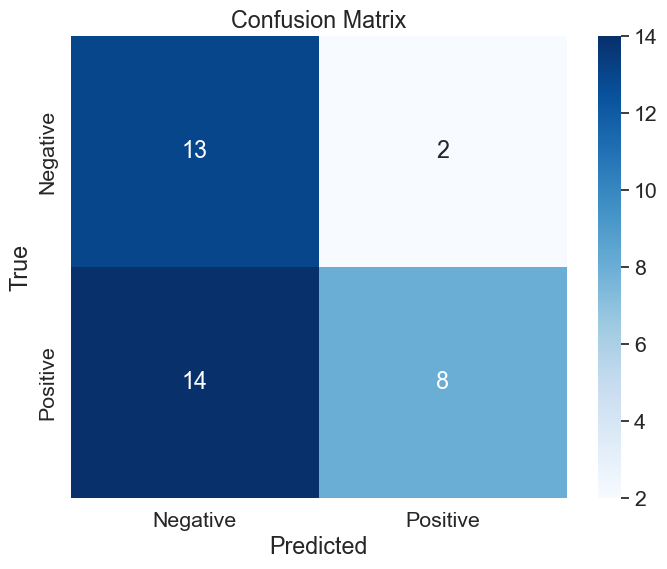

Wrong Buy_Act List:
HOTBRL 

SOLBRL 


Pred proft %: 1.0061948774921845
Gamble proft %: 1.0060813604073233
True proft %: 1.0068002519721009

Look Back: 11 / Total Loss: 17423315.175083946 / Sold Portion: 0.8333333333333334 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19641.94141', 'TruePrice: 19691.93   ', 'GambleProft: 1.004', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2497.3561  ', 'TruePrice: 2463.0     ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.70483    ', 'TruePrice: 3.74       ', 'GambleProft: 1.018', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0142     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.005', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['FTMBRL  ', 'LastPrice: 1.889      ', 'MyGamble: 1.89106    ', 'TruePrice: 1.923      ', 'GambleProft:

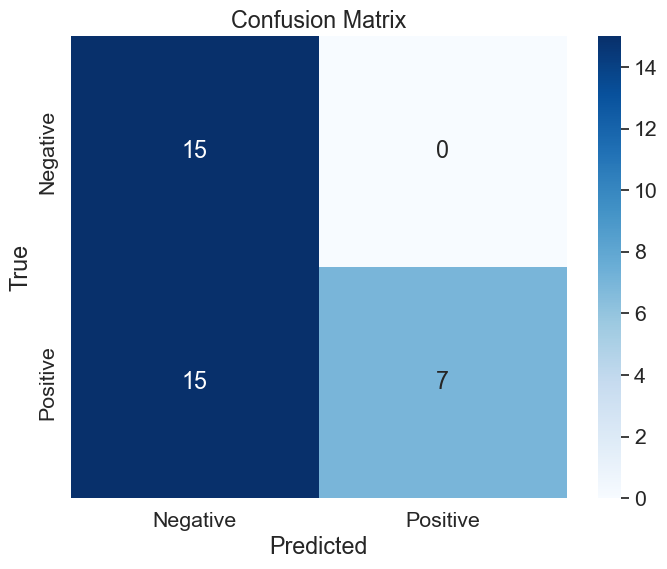


Pred proft %: 1.0008279840182919
Gamble proft %: 1.0008470305873673
True proft %: 1.0042356048696095

Look Back: 11 / Total Loss: 1399938.380131453 / Sold Portion: 0.5714285714285714 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19846.26473', 'TruePrice: 19691.93   ', 'GambleProft: 1.015', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2465.79517 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.007', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.18075    ', 'TruePrice: 3.125      ', 'GambleProft: 1.019', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.83484    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.008', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.62      ', 'MyGamble: 53.72765   ', 'TruePrice: 52.91      ', 'GambleProft: 1.002', 'TrueProft: 0.987', 'SoldStatu

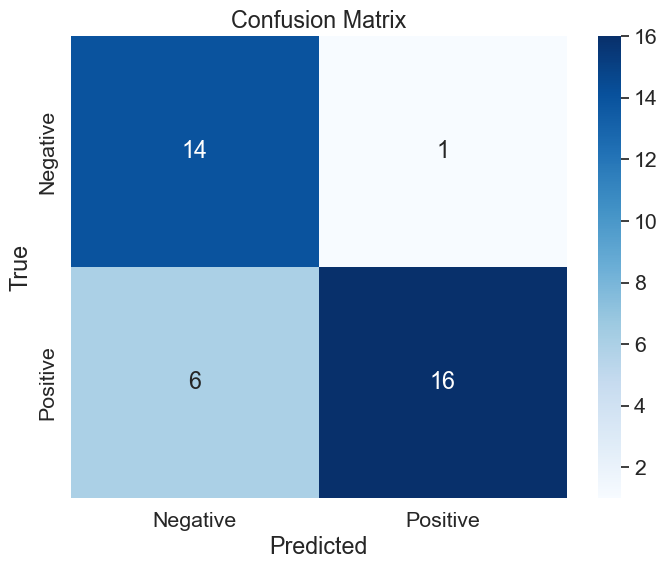

Wrong Buy_Act List:
DOTBRL 



In [24]:
for i in range(4):
    pred_eval(model_1, epochs = 100, lb_list = [11], ticker_list = symbols, print_info = False)


Pred proft %: 1.0028633081689597
Gamble proft %: 1.004031979046929
True proft %: 1.0023790171500915

Look Back: 11 / Total Loss: 118659128.76779702 / Sold Portion: 1.0 

['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.74232    ', 'TruePrice: 5.827      ', 'GambleProft: 1.013', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 67.57      ', 'MyGamble: 68.9214    ', 'TruePrice: 69.73      ', 'GambleProft: 1.02 ', 'TrueProft: 1.032', 'SoldStatus: 1', 'CorrectModel: 1']
['FISBRL  ', 'LastPrice: 1.682      ', 'MyGamble: 1.71305    ', 'TruePrice: 1.794      ', 'GambleProft: 1.018', 'TrueProft: 1.067', 'SoldStatus: 1', 'CorrectModel: 1']
['AVAXBRL ', 'LastPrice: 214.7      ', 'MyGamble: 217.30567  ', 'TruePrice: 217.2      ', 'GambleProft: 1.012', 'TrueProft: 1.012', 'SoldStatus: 1', 'Correct

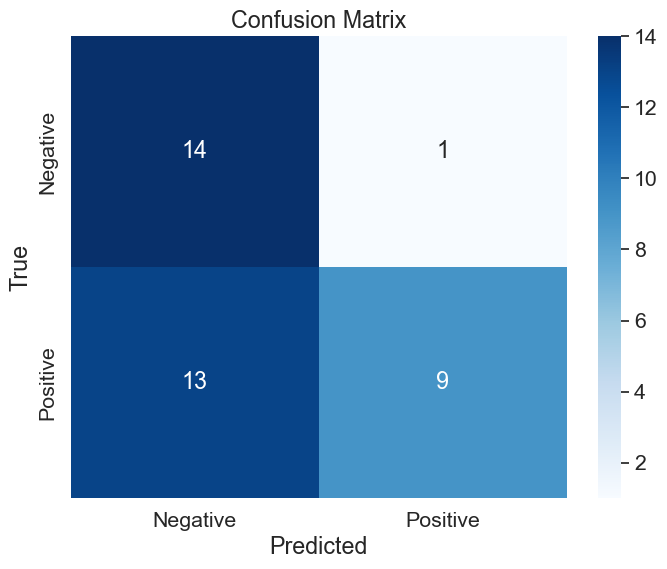

Wrong Buy_Act List:
SOLBRL 


Pred proft %: 1.0430514115413603
Gamble proft %: 1.0110032402684561
True proft %: 0.9863063799373574

Look Back: 11 / Total Loss: 9760301.465562098 / Sold Portion: 0.7272727272727273 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2462.2644  ', 'TruePrice: 2463.0     ', 'GambleProft: 1.005', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.18303    ', 'TruePrice: 3.125      ', 'GambleProft: 1.02 ', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.83397   ', 'TruePrice: 100.73     ', 'GambleProft: 1.006', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.68351    ', 'TruePrice: 3.74       ', 'GambleProft: 1.013', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.78775    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.02 ', '

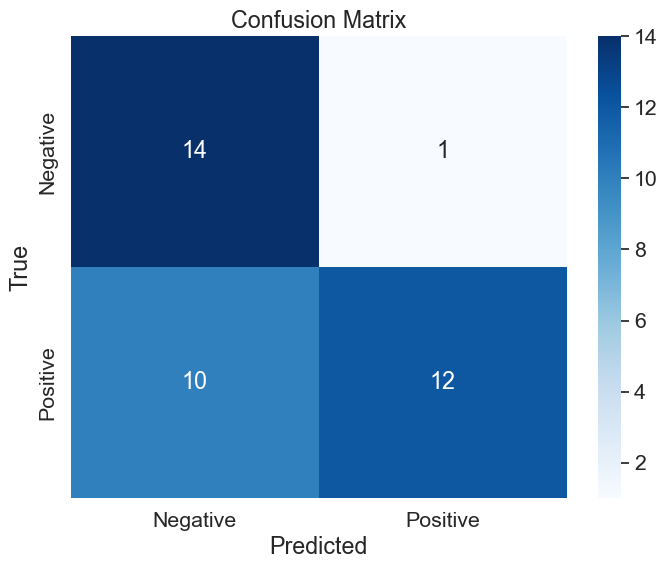

Wrong Buy_Act List:
AAVEBRL 


Pred proft %: 1.0061317060078803
Gamble proft %: 1.0053298228391203
True proft %: 1.0206424648461234

Look Back: 11 / Total Loss: 46205803.56894324 / Sold Portion: 0.5454545454545454 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.99295    ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.13294    ', 'TruePrice: 3.125      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 102.07376  ', 'TruePrice: 100.73     ', 'GambleProft: 1.029', 'TrueProft: 1.016', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.67028    ', 'TruePrice: 3.74       ', 'GambleProft: 1.009', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 

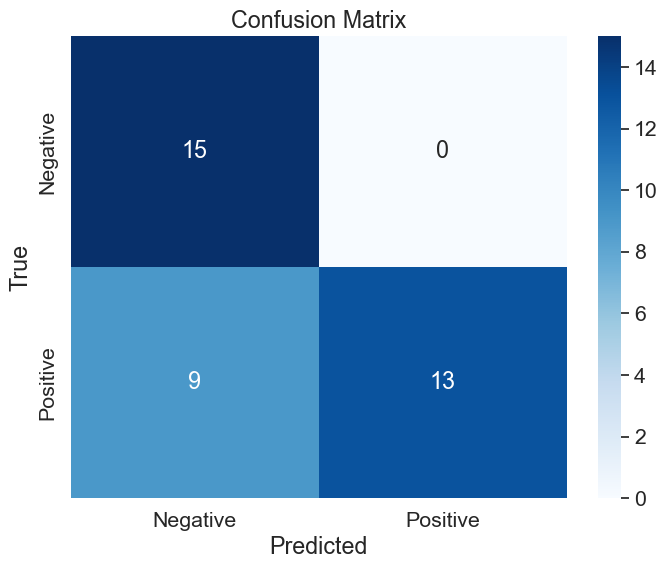


Pred proft %: 1.0035640224899616
Gamble proft %: 1.0025597311786407
True proft %: 1.004229028275556

Look Back: 11 / Total Loss: 1169967.285190047 / Sold Portion: 0.7142857142857143 

['BTCBRL  ', 'LastPrice: 343050.0   ', 'MyGamble: 343934.2215', 'TruePrice: 344444.0   ', 'GambleProft: 1.003', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19597.59373', 'TruePrice: 19691.93   ', 'GambleProft: 1.002', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.83321    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.006', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.71076    ', 'TruePrice: 3.74       ', 'GambleProft: 1.02 ', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.78775    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.02 ', 'TrueProft: 1.011', 'SoldStatus

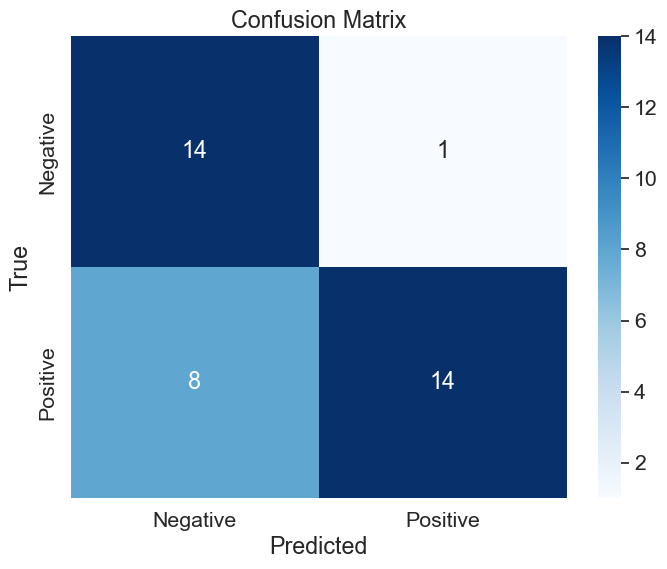

Wrong Buy_Act List:
SHIBBRL 



In [25]:
for i in range(4):
    pred_eval(model_2, epochs = 100, lb_list = [11], ticker_list = symbols, print_info = False)


Pred proft %: 1.0009777182590631
Gamble proft %: 1.0000228187880158
True proft %: 1.004058232334969

Look Back: 11 / Total Loss: 13670685.349056372 / Sold Portion: 0.5555555555555556 

['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.56015   ', 'TruePrice: 100.73     ', 'GambleProft: 1.004', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.64195    ', 'TruePrice: 3.74       ', 'GambleProft: 1.001', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382      ', 'MyGamble: 1.46515    ', 'TruePrice: 1.31       ', 'GambleProft: 1.06 ', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatu

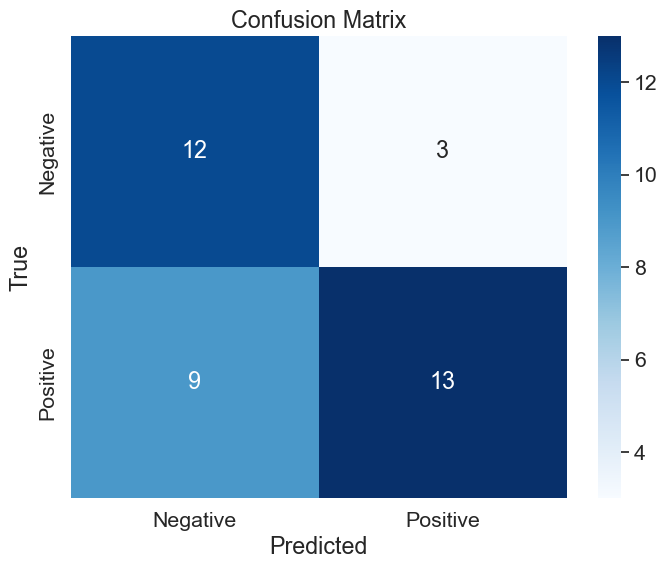

Wrong Buy_Act List:
DOTBRL 

ENJBRL 

SOLBRL 


Pred proft %: 1.0060163326401677
Gamble proft %: 1.0058035035572694
True proft %: 1.0000591509906986

Look Back: 11 / Total Loss: 95547996.66094807 / Sold Portion: 0.4444444444444444 

['HOTBRL  ', 'LastPrice: 0.0394     ', 'MyGamble: 0.04447    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.129', 'TrueProft: 0.98 ', 'SoldStatus: 0', 'CorrectModel: 0']
['SOLBRL  ', 'LastPrice: 729.1      ', 'MyGamble: 731.93939  ', 'TruePrice: 726.4      ', 'GambleProft: 1.004', 'TrueProft: 0.996', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 67.57      ', 'MyGamble: 68.73338   ', 'TruePrice: 69.73      ', 'GambleProft: 1.017', 'TrueProft: 1.032', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.71      ', 'MyGamble: 38.97905   ', 'TruePrice: 38.75      ', 'GambleProft: 1.007', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['FISBRL  ', 'LastPrice: 1.682      ', 'MyGamble: 1.71564    ', 'TruePrice: 1.794      ', 'Gamb

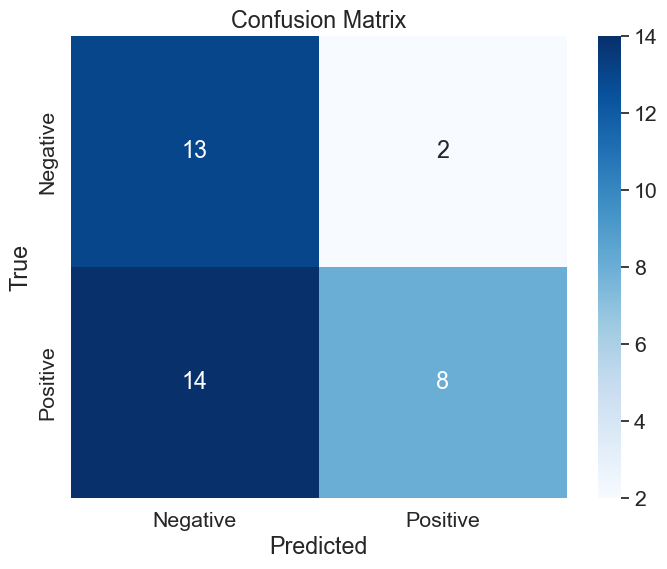

Wrong Buy_Act List:
HOTBRL 

SOLBRL 


Pred proft %: 1.007310470952527
Gamble proft %: 1.0061580009848567
True proft %: 1.0179715035576733

Look Back: 11 / Total Loss: 17902638.495555848 / Sold Portion: 0.7272727272727273 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.98037    ', 'TruePrice: 4.977      ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.40779   ', 'TruePrice: 100.73     ', 'GambleProft: 1.002', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.84517    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.02 ', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.65425    ', 'TruePrice: 3.74       ', 'GambleProft: 1.004', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01427    ', 'TruePrice: 0.01493    ', 'GambleProft: 

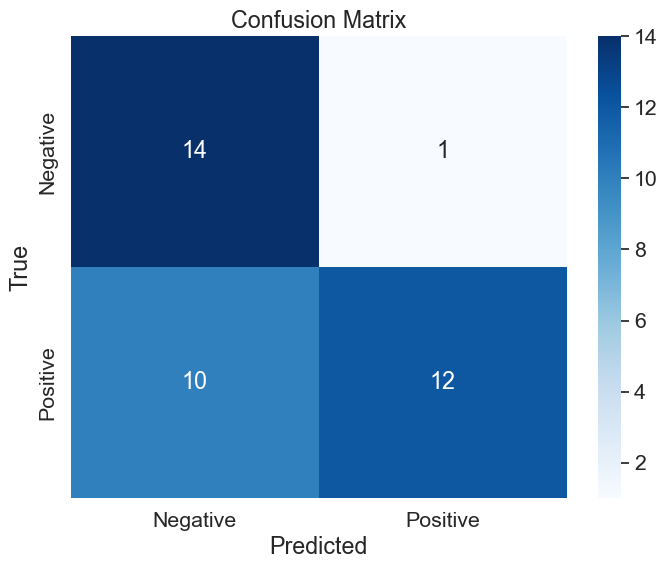

Wrong Buy_Act List:
HOTBRL 


Pred proft %: 1.0072766797564652
Gamble proft %: 1.0066940278606644
True proft %: 1.0212113609597315

Look Back: 11 / Total Loss: 116956821.09688583 / Sold Portion: 0.7 

['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.14322    ', 'TruePrice: 3.125      ', 'GambleProft: 1.007', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.5187    ', 'TruePrice: 100.73     ', 'GambleProft: 1.003', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.65017    ', 'TruePrice: 3.74       ', 'GambleProft: 1.003', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01427    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.011', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.0

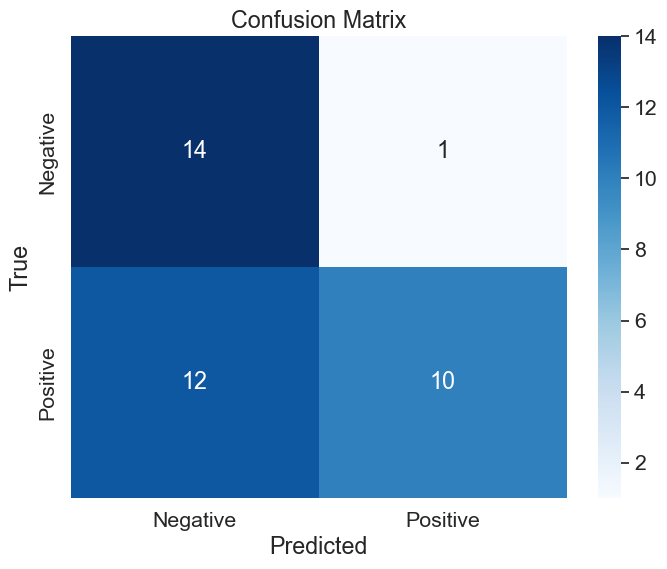

Wrong Buy_Act List:
HOTBRL 



In [26]:
for i in range(4):
    pred_eval(model_3, epochs = 100, lb_list = [11], ticker_list = symbols, print_info = False)


Pred proft %: 1.0154732449559993
Gamble proft %: 1.0080973376209506
True proft %: 1.0029818903050833

Look Back: 11 / Total Loss: 20703433.271920785 / Sold Portion: 0.75 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19711.24219', 'TruePrice: 19691.93   ', 'GambleProft: 1.008', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.17883    ', 'TruePrice: 3.125      ', 'GambleProft: 1.018', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 101.1738   ', 'TruePrice: 100.73     ', 'GambleProft: 1.02 ', 'TrueProft: 1.016', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.70318    ', 'TruePrice: 3.74       ', 'GambleProft: 1.018', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'Corre

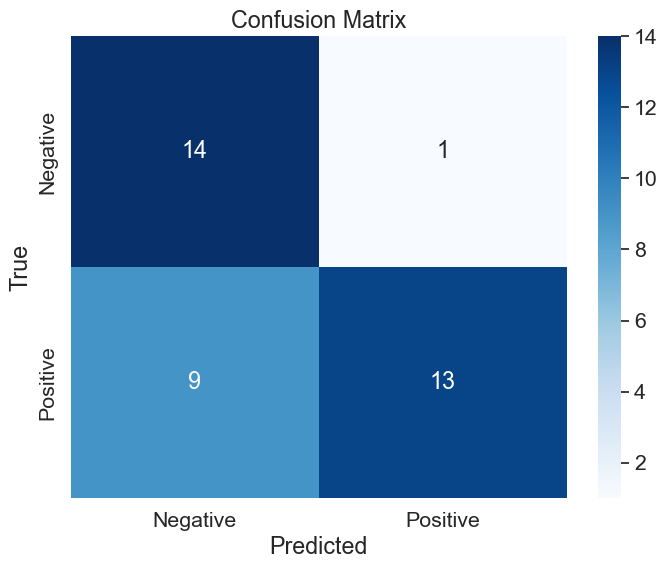

Wrong Buy_Act List:
AAVEBRL 


Pred proft %: 1.0016483573692403
Gamble proft %: 1.0032110944383723
True proft %: 1.006554926679204

Look Back: 11 / Total Loss: 5288773.433278314 / Sold Portion: 0.45454545454545453 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2487.85229 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.016', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.98587    ', 'TruePrice: 4.977      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.15205    ', 'TruePrice: 3.125      ', 'GambleProft: 1.01 ', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.44647   ', 'TruePrice: 100.73     ', 'GambleProft: 1.003', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.65115    ', 'TruePrice: 3.74       ', 'GambleProft: 1.004', 

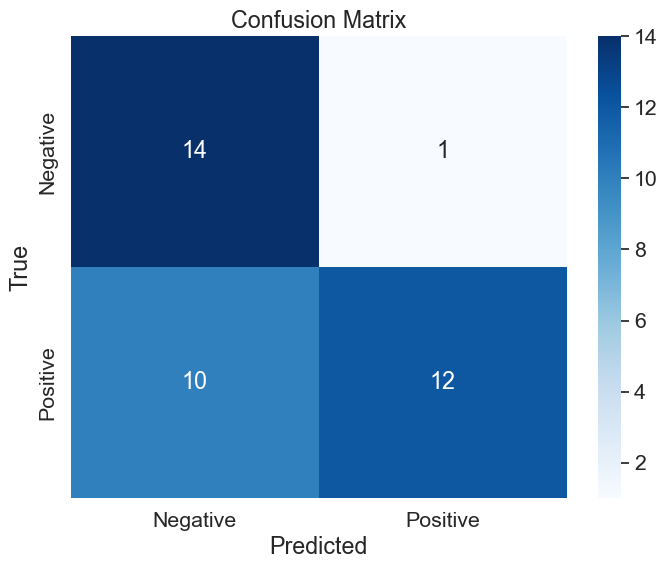

Wrong Buy_Act List:
SOLBRL 


Pred proft %: 1.0114166916945528
Gamble proft %: 1.011501064261889
True proft %: 1.0094080816787372

Look Back: 11 / Total Loss: 76860312.1482948 / Sold Portion: 0.875 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2484.21411 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.014', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.74576    ', 'TruePrice: 5.827      ', 'GambleProft: 1.014', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['FISBRL  ', 'LastPrice: 1.682      ', 'MyGamble: 1.70341    ', 'TruePrice: 1.794      ', 'GambleProft: 1.013', 'TrueProft: 1.067', 'SoldStatus: 1', 'CorrectModel: 1']
['AVAXBRL ', 'LastPrice: 214.7      ', 'MyGamble: 215.18705  ', 'TruePrice: 217.2      ', 'GambleProft: 1.002', 'TrueProft: 1.01

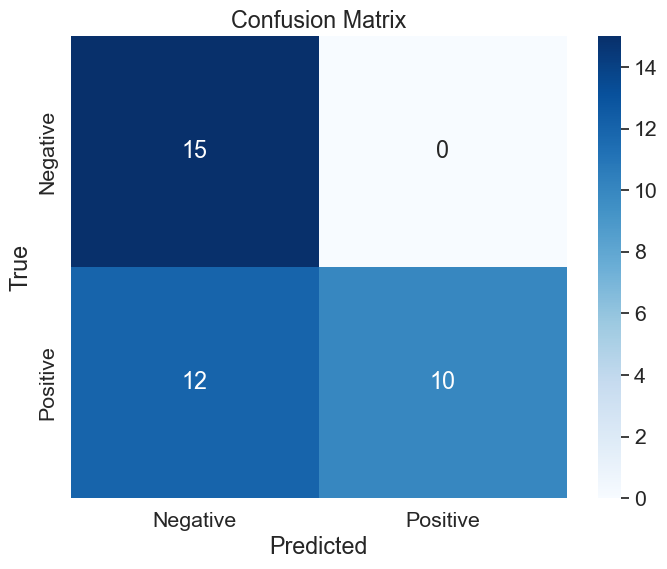


Pred proft %: 0.9999308186464484
Gamble proft %: 1.000346137102372
True proft %: 1.0069617546028486

Look Back: 11 / Total Loss: 23136745.08866778 / Sold Portion: 0.75 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2453.67993 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.002', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.18418    ', 'TruePrice: 3.125      ', 'GambleProft: 1.02 ', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.84265    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.017', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.68892    ', 'TruePrice: 3.74       ', 'GambleProft: 1.014', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.78686    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.019', 'TrueProft: 1.011', 'SoldStatus: 0', 'Correct

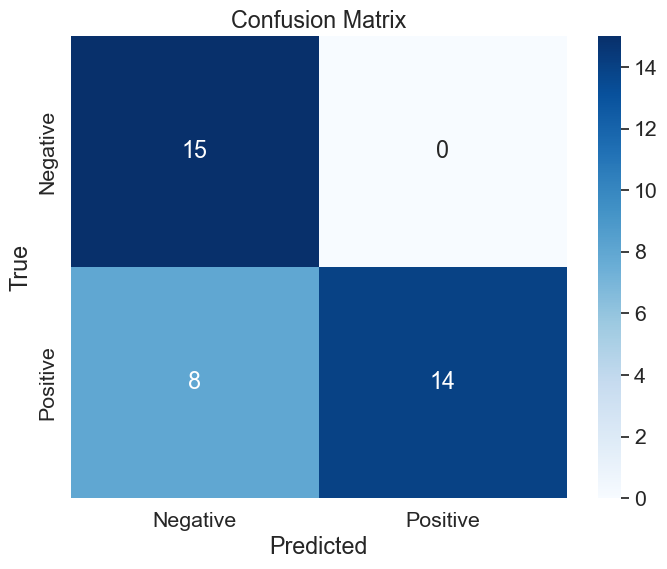


Pred proft %: 1.0177358301418187
Gamble proft %: 1.0174837440726008
True proft %: 1.0047283992027929

Look Back: 11 / Total Loss: 10428740.812130496 / Sold Portion: 0.5384615384615384 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2483.18359 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.014', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.57584  ', 'TruePrice: 100.73     ', 'GambleProft: 1.014', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.62      ', 'MyGamble: 53.87875   ', 'TruePrice: 52.91      ', 'GambleProft: 1.005', 'TrueProft: 0.987', 'SoldStatus: 0', 'CorrectModel: 0']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.78775    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.02 ', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.70933    ', 'TruePrice: 5.827      ', 'GambleProft: 1.008', 'TrueProft: 1.028', 'SoldStat

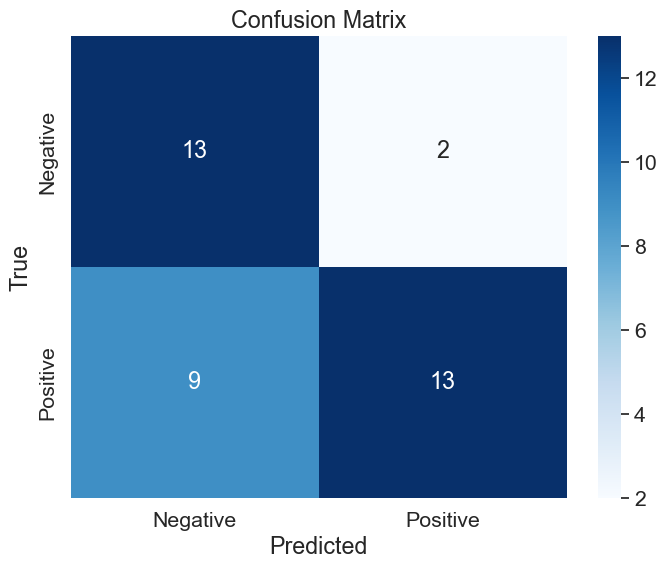

Wrong Buy_Act List:
DOTBRL 

SOLBRL 


Pred proft %: 1.0094459546857366
Gamble proft %: 1.0089357966835657
True proft %: 1.0151856726518007

Look Back: 11 / Total Loss: 25540137.6366754 / Sold Portion: 0.7 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.98117    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.72383    ', 'TruePrice: 3.74       ', 'GambleProft: 1.024', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0394     ', 'MyGamble: 0.04847    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.23 ', 'TrueProft: 0.98 ', 'SoldStatus: 0', 'CorrectModel: 0']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.76033    ', 'TruePrice: 5.827      ', 'GambleProft: 1.017', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['SHIBBRL ', 'LastPrice: 0.00018    ', 'MyGamble: 0.00018    ', 'TruePrice: 0.00018    ', 'GambleProft: 1.02 ', 'TruePro

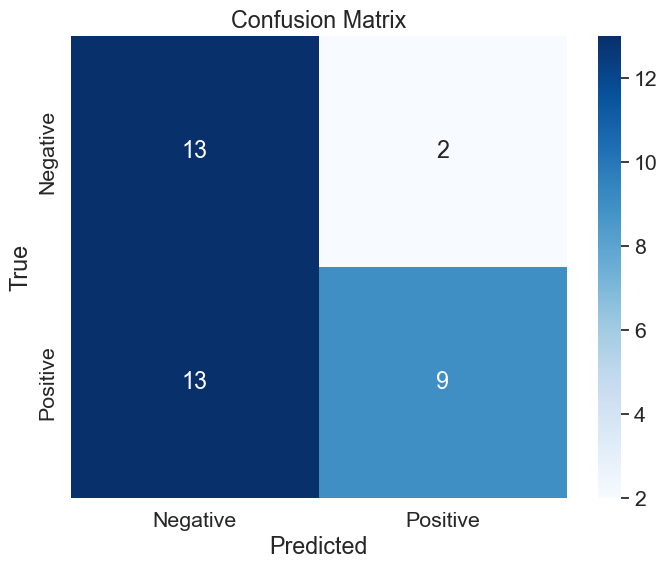

Wrong Buy_Act List:
HOTBRL 

SHIBBRL 



In [ ]:
for i in range(10):
    pred_eval(model_1, epochs = 100, lb_list = [11], ticker_list = symbols, print_info = False)


Pred proft %: 1.0119093928547167
Gamble proft %: 1.0109040771843898
True proft %: 1.004220685721709

Look Back: 11 / Total Loss: 4158145.681989283 / Sold Portion: 0.7857142857142857 

['BTCBRL  ', 'LastPrice: 343050.0   ', 'MyGamble: 346902.90609', 'TruePrice: 344444.0   ', 'GambleProft: 1.011', 'TrueProft: 1.004', 'SoldStatus: 0', 'CorrectModel: 1']
['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19686.17888', 'TruePrice: 19691.93   ', 'GambleProft: 1.007', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2455.08765 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.002', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.13432    ', 'TruePrice: 3.125      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.70981  ', 'TruePrice: 100.73     ', 'GambleProft: 1.015', 'TrueProft: 1.016', 'SoldStatu

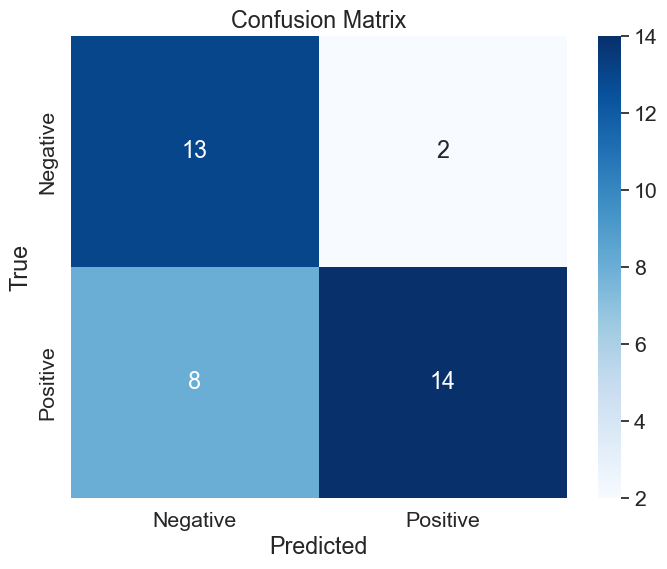

Wrong Buy_Act List:
SHIBBRL 

SOLBRL 


Pred proft %: 1.0012970664866838
Gamble proft %: 1.0002974089677767
True proft %: 1.0041035579970985

Look Back: 11 / Total Loss: 3765455.3528600424 / Sold Portion: 0.6666666666666666 

['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.47627   ', 'TruePrice: 100.73     ', 'GambleProft: 1.003', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 444.2      ', 'MyGamble: 445.92459  ', 'TruePrice: 456.6      ', 'GambleProft: 1.004', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.67118    ', 'TruePrice: 3.74       ', 'GambleProft: 1.009', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 1.02461    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.327', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft

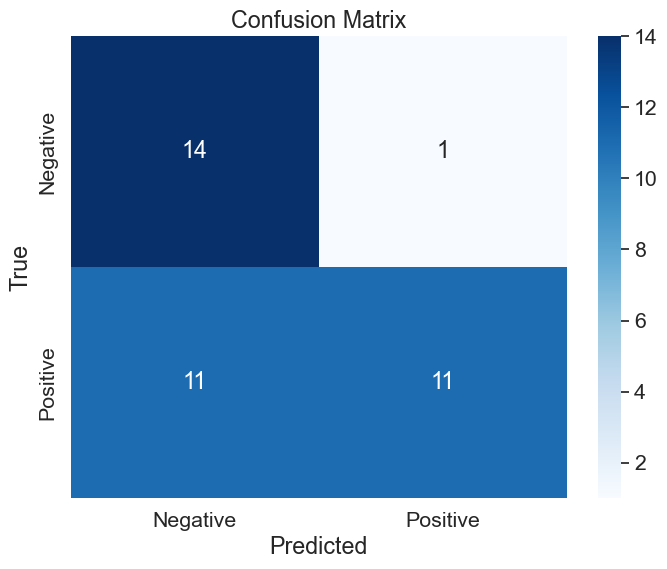

Wrong Buy_Act List:
HOTBRL 


Pred proft %: 1.011340918379105
Gamble proft %: 1.0112450879180044
True proft %: 1.0066615810453527

Look Back: 11 / Total Loss: 25904456.896214783 / Sold Portion: 0.8 

['USDTBRL ', 'LastPrice: 5.036      ', 'MyGamble: 5.04618    ', 'TruePrice: 5.042      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2476.0957  ', 'TruePrice: 2463.0     ', 'GambleProft: 1.011', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.54746  ', 'TruePrice: 100.73     ', 'GambleProft: 1.014', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.6479     ', 'TruePrice: 3.74       ', 'GambleProft: 1.003', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.05

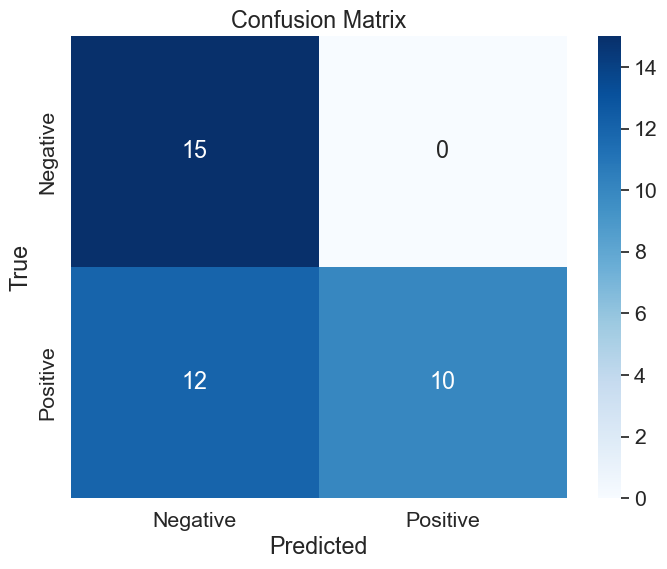


Pred proft %: 1.0031800056139681
Gamble proft %: 1.0031149552168894
True proft %: 1.0125072311647711

Look Back: 11 / Total Loss: 120268763.96414766 / Sold Portion: 0.75 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.97828    ', 'TruePrice: 4.977      ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.13306    ', 'TruePrice: 3.125      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.71076    ', 'TruePrice: 3.74       ', 'GambleProft: 1.02 ', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77614    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.005', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.77932    ', 'TruePrice: 5.827      ', 'GambleProft: 1.02 ', 'TrueProft: 1.028', 'SoldStatus: 1', 'Corre

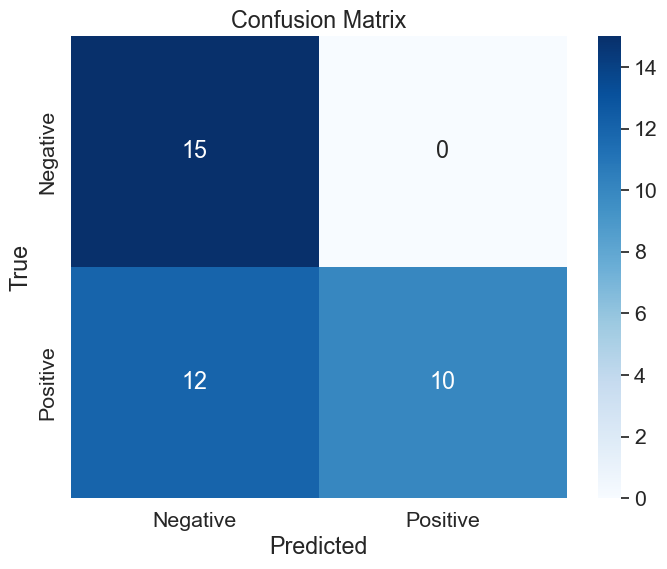


Pred proft %: 1.0042529864980443
Gamble proft %: 1.0042767515140836
True proft %: 1.0068852652651832

Look Back: 11 / Total Loss: 4321895.7061668895 / Sold Portion: 0.7142857142857143 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19621.06055', 'TruePrice: 19691.93   ', 'GambleProft: 1.003', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2479.80103 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.013', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.68033    ', 'TruePrice: 3.74       ', 'GambleProft: 1.012', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.69339    ', 'TruePrice: 5.827      ', 'GambleProft: 1.005', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.71      ', 'MyGamble: 38.83435   ', 'TruePrice: 38.75      ', 'GambleProft: 1.003', 'TrueProft: 1.001', 'SoldStat

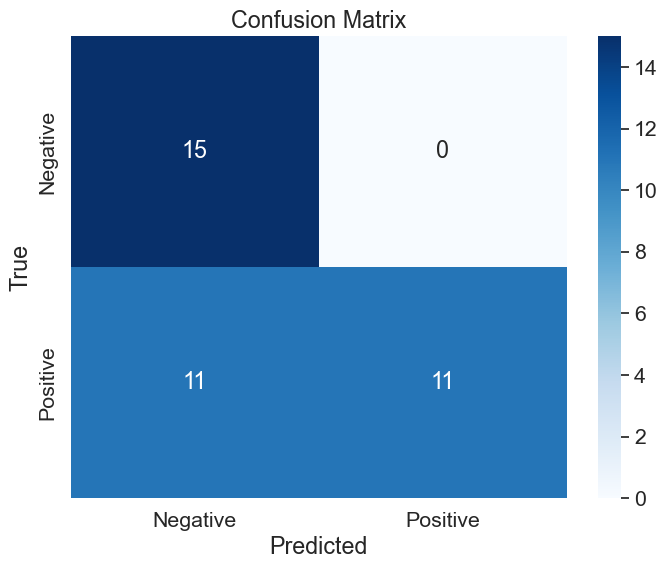


Pred proft %: 1.0152830004478195
Gamble proft %: 1.0142730615605287
True proft %: 1.0025775225071343

Look Back: 11 / Total Loss: 65328976.57109557 / Sold Portion: 0.5 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19648.23249', 'TruePrice: 19691.93   ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.99288    ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.19498    ', 'TruePrice: 3.125      ', 'GambleProft: 1.023', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.92048   ', 'TruePrice: 100.73     ', 'GambleProft: 1.007', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.7902     ', 'TruePrice: 0.7807     ', 'GambleProft: 1.023', 'TrueProft: 1.011', 'SoldStatus: 0', 'Correct

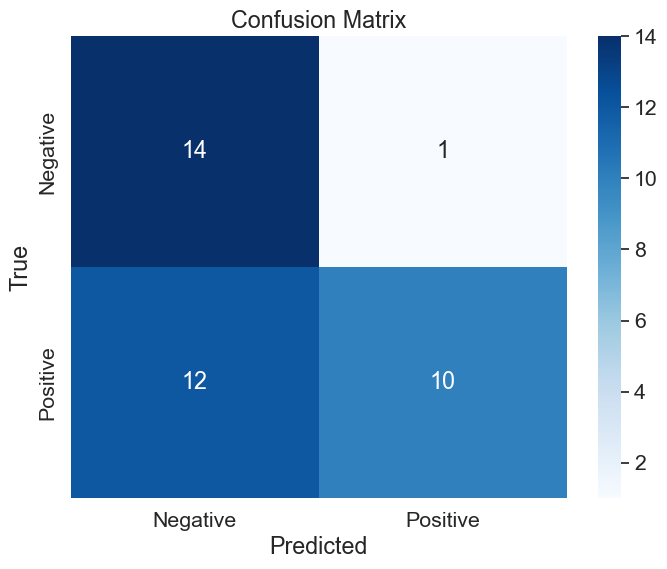

Wrong Buy_Act List:
AAVEBRL 


Pred proft %: 1.1055491271858024
Gamble proft %: 1.104764872670309
True proft %: 0.9640245941827498

Look Back: 11 / Total Loss: 76584164.07159178 / Sold Portion: 0.6666666666666666 

['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.71507    ', 'TruePrice: 5.827      ', 'GambleProft: 1.009', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 67.57      ', 'MyGamble: 69.67827   ', 'TruePrice: 69.73      ', 'GambleProft: 1.031', 'TrueProft: 1.032', 'SoldStatus: 1', 'CorrectModel: 1']
['AAVEBRL ', 'LastPrice: 1833.0     ', 'MyGamble: 2054.79715 ', 'TruePrice: 1751.0     ', 'GambleProft: 1.121', 'TrueProft: 0.955', 'SoldStatus: 0', 'CorrectModel: 0']
['FISBRL  ', 'LastPrice: 1.682      ', 'MyGamble: 1.71564    ', 'TruePrice: 1.794      ', 'GambleProft: 1.02 ', '

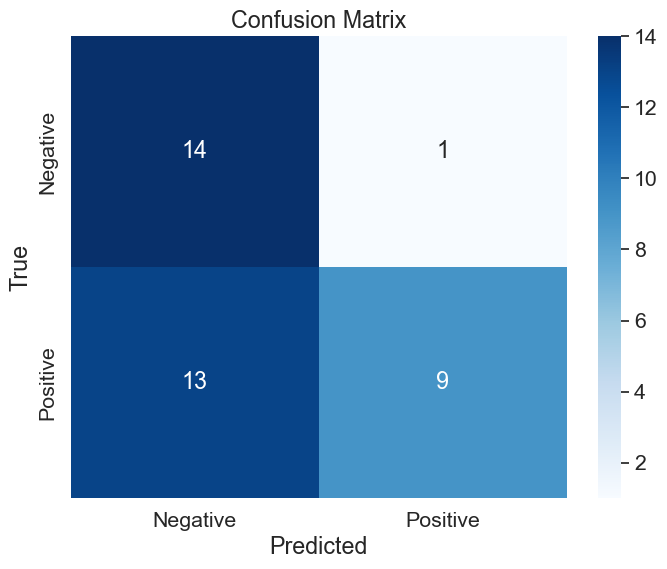

Wrong Buy_Act List:
AAVEBRL 


Pred proft %: 1.008722876511581
Gamble proft %: 1.0077538648650752
True proft %: 1.0067344714724644

Look Back: 11 / Total Loss: 6066707.002074702 / Sold Portion: 0.8888888888888888 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19708.54907', 'TruePrice: 19691.93   ', 'GambleProft: 1.008', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.50716   ', 'TruePrice: 100.73     ', 'GambleProft: 1.003', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.68134    ', 'TruePrice: 3.74       ', 'GambleProft: 1.012', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01421    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.006', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['SOLBRL  ', 'LastPrice: 729.1      ', 'MyGamble: 735.29517  ', 'TruePrice: 726.4      ', 'GambleProft: 1.008', '

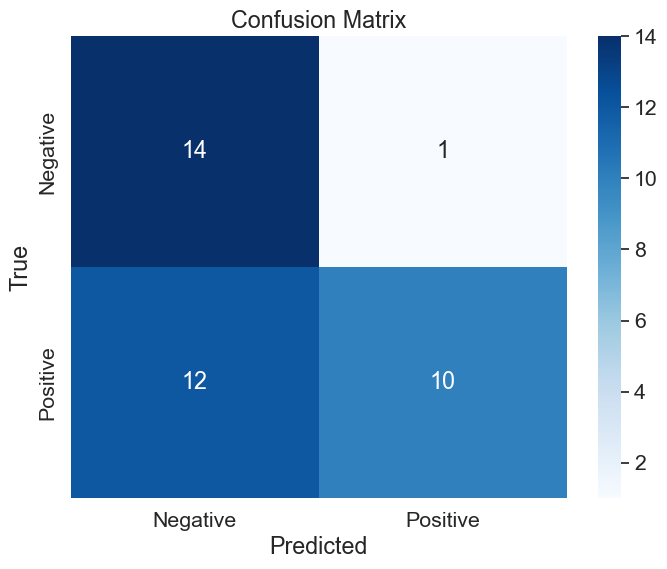

Wrong Buy_Act List:
SOLBRL 


Pred proft %: 1.006983366861842
Gamble proft %: 1.005976783364708
True proft %: 1.0038162330466718

Look Back: 11 / Total Loss: 864950.5855322449 / Sold Portion: 0.75 

['BTCBRL  ', 'LastPrice: 343050.0   ', 'MyGamble: 345034.52634', 'TruePrice: 344444.0   ', 'GambleProft: 1.006', 'TrueProft: 1.004', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2460.96162 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.005', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['SOLBRL  ', 'LastPrice: 729.1      ', 'MyGamble: 732.0056   ', 'TruePrice: 726.4      ', 'GambleProft: 1.004', 'TrueProft: 0.996', 'SoldStatus: 0', 'CorrectModel: 0']
['CAKEBRL ', 'LastPrice: 67.57      ', 'MyGamble: 67.93148   ', 'TruePrice: 69.73      ', 'GambleProft: 1.005', 'TrueProft: 1.032', 'SoldStatus: 1', 'CorrectModel: 1']
['AAVEBRL ', 'LastPrice: 1833.0     ', 'MyGamble: 1914.79386 ', 'TruePrice: 1751.0     ', 'GambleProft: 1.045', 'TrueProft: 0.95

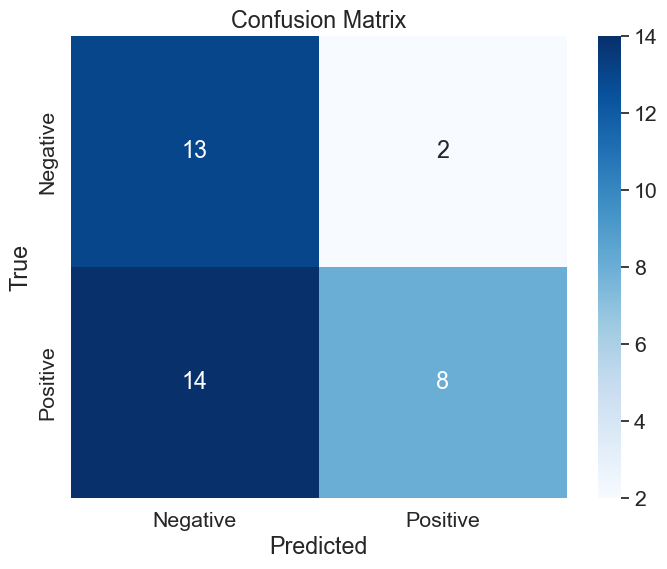

Wrong Buy_Act List:
SOLBRL 

AAVEBRL 


Pred proft %: 1.0010761175982643
Gamble proft %: 1.0001783537112572
True proft %: 1.0042384969325173

Look Back: 11 / Total Loss: 3023576.8195388215 / Sold Portion: 0.6 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19582.42922', 'TruePrice: 19691.93   ', 'GambleProft: 1.001', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2483.30273 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.014', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.14805    ', 'TruePrice: 3.125      ', 'GambleProft: 1.008', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.70507    ', 'TruePrice: 5.827      ', 'GambleProft: 1.007', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 67.57      ', 'MyGamble: 68.7925    ', 'TruePrice: 69.73      ', 'GambleProft: 1.018', 'True

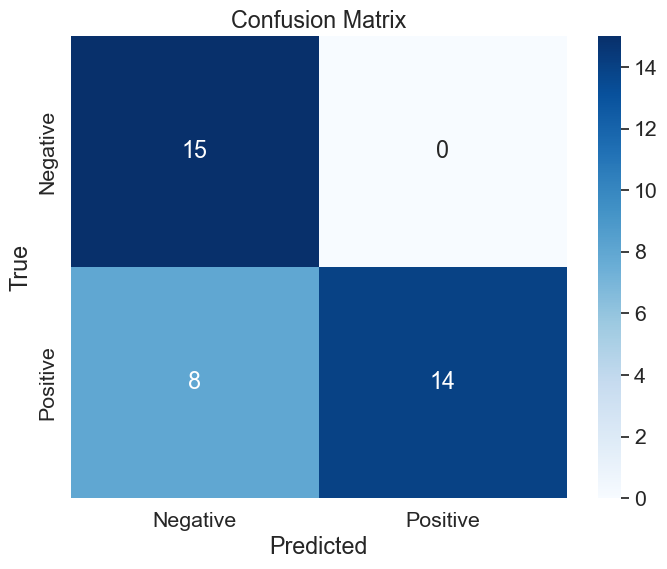

In [31]:
for i in range(10):
    pred_eval(model_2, epochs = 100, lb_list = [11], ticker_list = symbols, print_info = False)


Pred proft %: 0.9999593641531977
Gamble proft %: 1.0015783511756007
True proft %: 1.0237041235412219

Look Back: 11 / Total Loss: 6691632.049723672 / Sold Portion: 0.625 

['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01437    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.018', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00114    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.138', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.74503    ', 'TruePrice: 5.827      ', 'GambleProft: 1.014', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.71      ', 'MyGamble: 39.0484    ', 'TruePrice: 38.75      ', 'GambleProft: 1.009', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['FISBRL  ', 'LastPrice: 1.682      ', 'MyGamble: 1.71564    ', 'TruePrice: 1.794      ', 'GambleProft: 1.02 ', 'TrueProft: 1.067', 'SoldStatus: 1', 'Corre

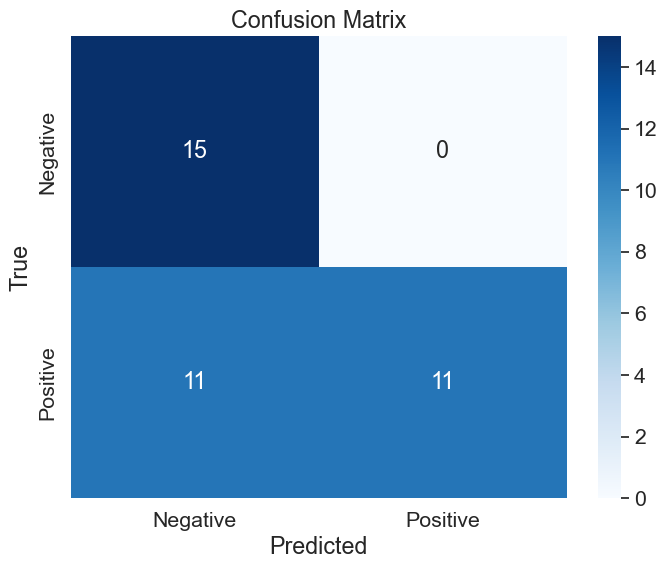


Pred proft %: 1.0001667160548402
Gamble proft %: 1.0005126058878009
True proft %: 1.0042252087036347

Look Back: 11 / Total Loss: 32077416.633743837 / Sold Portion: 0.8333333333333334 

['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 67.57      ', 'MyGamble: 68.80543   ', 'TruePrice: 69.73      ', 'GambleProft: 1.018', 'TrueProft: 1.032', 'SoldStatus: 1', 'CorrectModel: 1']
['AXSBRL  ', 'LastPrice: 38.71      ', 'MyGamble: 38.77283   ', 'TruePrice: 38.75      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['FISBRL  ', 'LastPrice: 1.682      ', 'MyGamble: 1.74851    ', 'TruePrice: 1.794      ', 'GambleProft: 1.04 ', 'TrueProft: 1.067', 'SoldStatus: 1', 'CorrectModel: 1']
['GALABRL ', 'LastPrice: 0.2204     ', 'MyGamble: 0.22481    ', 'TruePrice: 0.2828     ', 'GambleProft: 1.02 ', 'TrueProft: 1.283', 'SoldStat

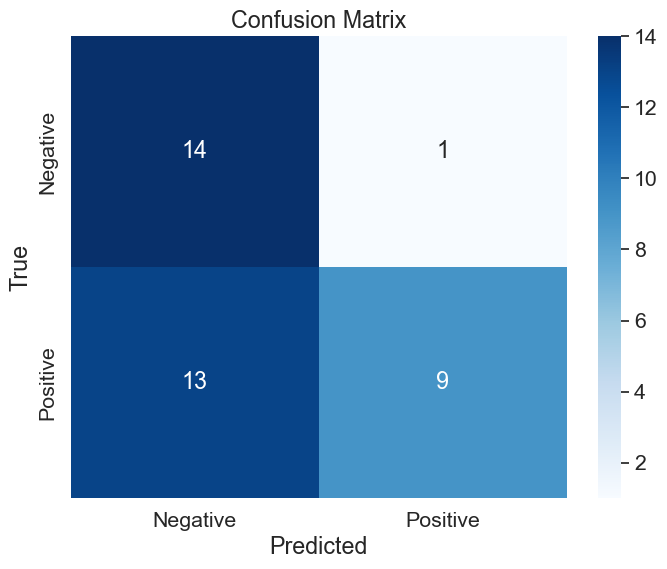

Wrong Buy_Act List:
SOLBRL 


Pred proft %: 1.0110641110375893
Gamble proft %: 1.0100601795629653
True proft %: 1.0074474502056165

Look Back: 11 / Total Loss: 18017895.14048644 / Sold Portion: 0.5 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19749.03003', 'TruePrice: 19691.93   ', 'GambleProft: 1.01 ', 'TrueProft: 1.007', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.81908   ', 'TruePrice: 100.73     ', 'GambleProft: 1.006', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 444.2      ', 'MyGamble: 453.084    ', 'TruePrice: 456.6      ', 'GambleProft: 1.02 ', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.02043    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.447', 'TrueProft: 1.057', 'SoldStatus: 0', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0394     ', 'MyGamble: 0.05097    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.294', 'TrueProft: 0.98

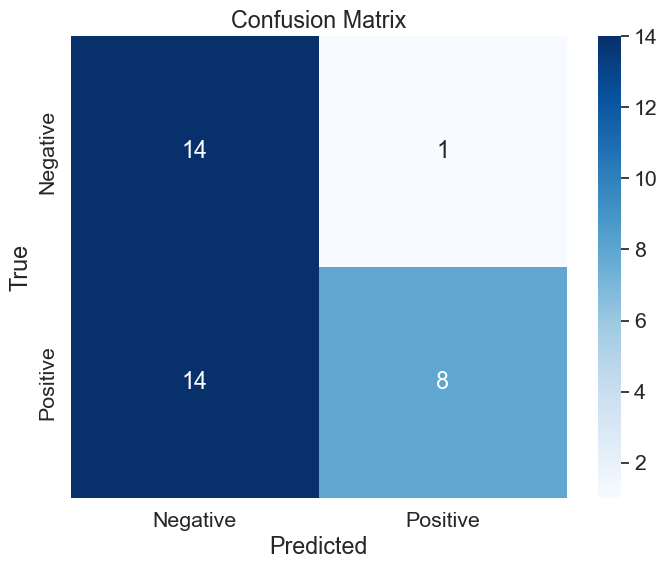

Wrong Buy_Act List:
HOTBRL 


Pred proft %: 1.0125831781154704
Gamble proft %: 1.0115821518013797
True proft %: 0.9995511307109217

Look Back: 11 / Total Loss: 5315372.445491051 / Sold Portion: 0.3333333333333333 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 5.02975    ', 'TruePrice: 4.977      ', 'GambleProft: 1.011', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.48248   ', 'TruePrice: 100.73     ', 'GambleProft: 1.003', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00116    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.161', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0394     ', 'MyGamble: 0.05067    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.286', 'TrueProft: 0.98 ', 'SoldStatus: 0', 'CorrectModel: 0']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.70313    ', 'TruePrice: 5.827      ', 'GambleProft: 1.007', '

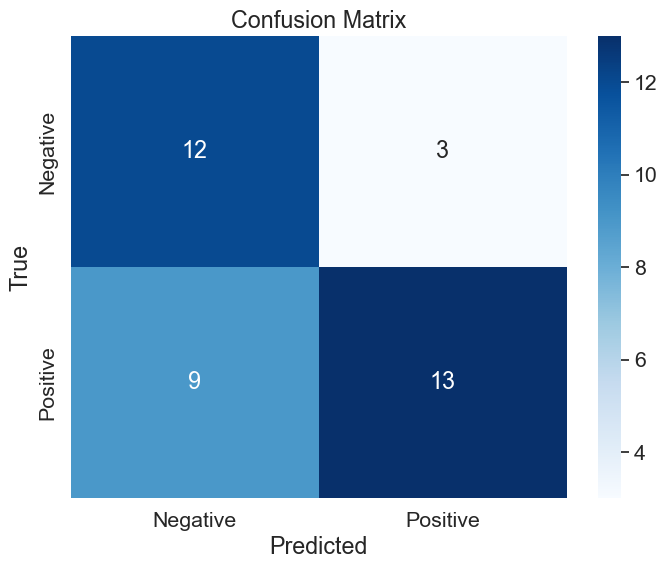

Wrong Buy_Act List:
HOTBRL 

SOLBRL 

GMTBRL 


Pred proft %: 1.0459129042666018
Gamble proft %: 1.0136820186868611
True proft %: 0.9858577590340327

Look Back: 11 / Total Loss: 14214219.341683233 / Sold Portion: 0.6 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2473.5301  ', 'TruePrice: 2463.0     ', 'GambleProft: 1.01 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.33138   ', 'TruePrice: 100.73     ', 'GambleProft: 1.001', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.78775    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.02 ', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['ENJBRL  ', 'LastPrice: 1.382      ', 'MyGamble: 1.40964    ', 'TruePrice: 1.31       ', 'GambleProft: 1.02 ', 'TrueProft: 0.948', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 

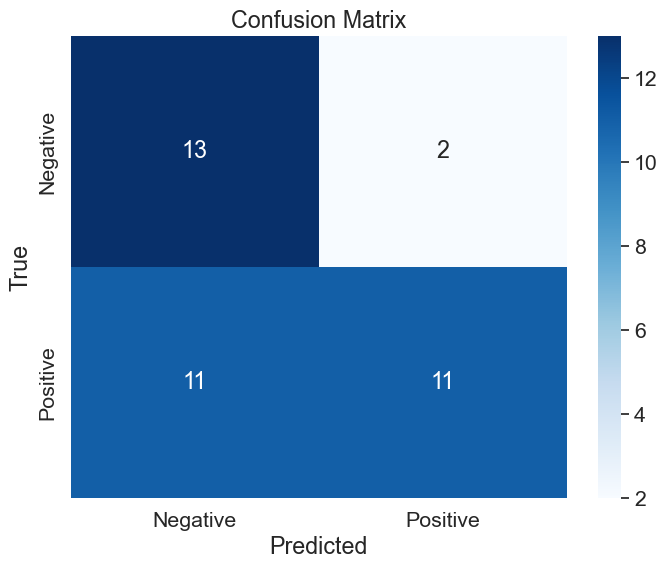

Wrong Buy_Act List:
ENJBRL 

AAVEBRL 


Pred proft %: 1.0018704232533926
Gamble proft %: 1.0009746658249932
True proft %: 1.0068730555842234

Look Back: 11 / Total Loss: 43033349.18533203 / Sold Portion: 0.7142857142857143 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2451.85059 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.001', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.68834    ', 'TruePrice: 3.74       ', 'GambleProft: 1.014', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01415    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.002', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00151    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.507', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.72601    ', 'TruePrice: 5.827      ', 'GambleProft:

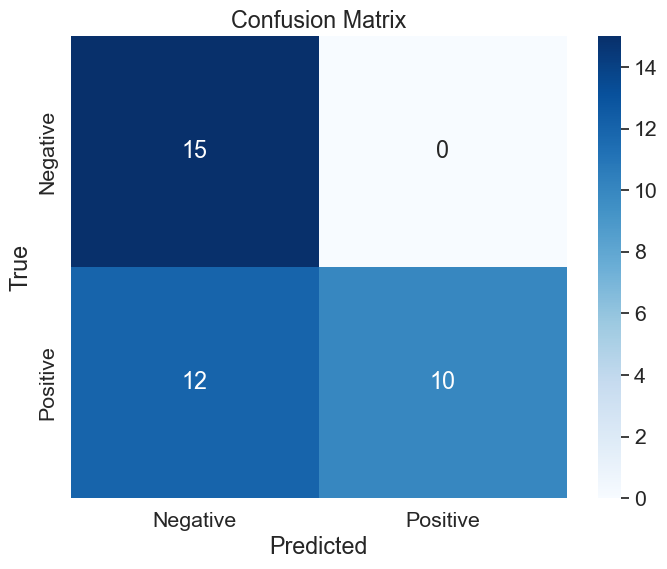


Pred proft %: 0.9990234412110455
Gamble proft %: 1.0001041228992378
True proft %: 1.0040889574120713

Look Back: 11 / Total Loss: 12047433.50943325 / Sold Portion: 0.5555555555555556 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2482.62183 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.014', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.99417    ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.85028   ', 'TruePrice: 100.73     ', 'GambleProft: 1.007', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01436    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.017', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00101    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.008', 'TrueProft: 1.006', 'SoldStatu

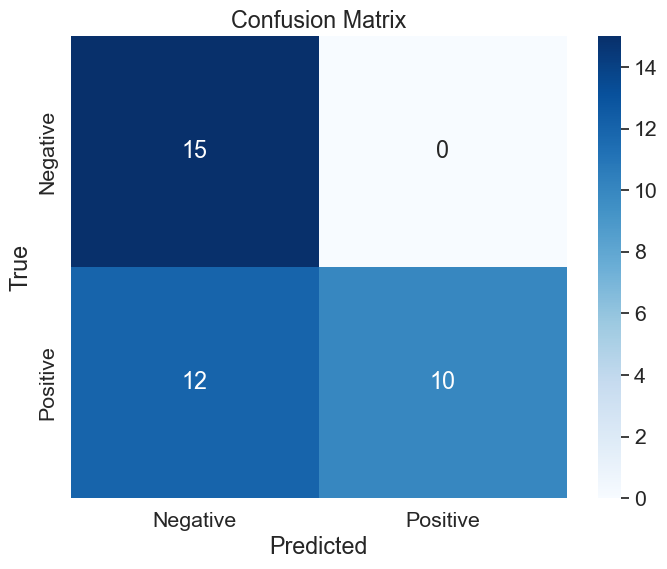


Pred proft %: 0.9999486255618695
Gamble proft %: 1.0003053758293017
True proft %: 1.0042190881641389

Look Back: 11 / Total Loss: 10524202.53268477 / Sold Portion: 0.8888888888888888 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19666.98438', 'TruePrice: 19691.93   ', 'GambleProft: 1.006', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.68521    ', 'TruePrice: 3.74       ', 'GambleProft: 1.013', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77508    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.004', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00111    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.106', 'TrueProft: 1.006', 'SoldStatu

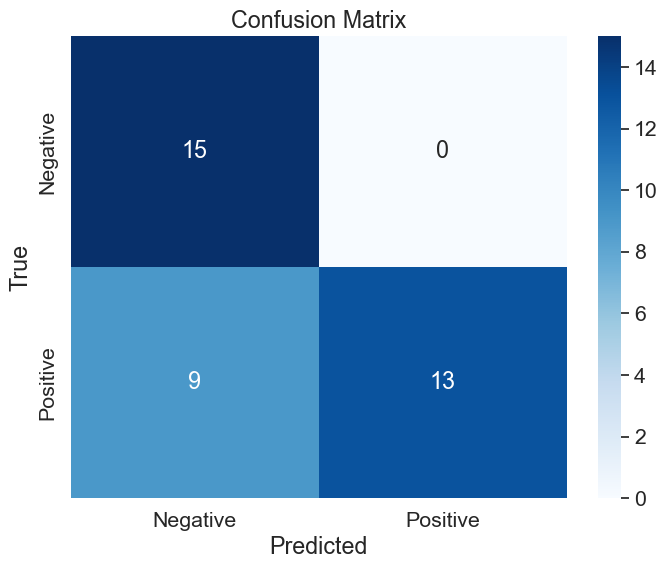


Pred proft %: 1.0009776403852466
Gamble proft %: 1.0001752424889627
True proft %: 1.006622479710781

Look Back: 11 / Total Loss: 19013336.3079037 / Sold Portion: 0.5 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.9938     ', 'TruePrice: 4.977      ', 'GambleProft: 1.004', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.1271     ', 'TruePrice: 3.125      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.64668    ', 'TruePrice: 3.74       ', 'GambleProft: 1.002', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00101    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.007', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0394     ', 'MyGamble: 0.04775    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.212', 'TrueProft: 0.98 ', 'SoldStatus: 0', 'CorrectMo

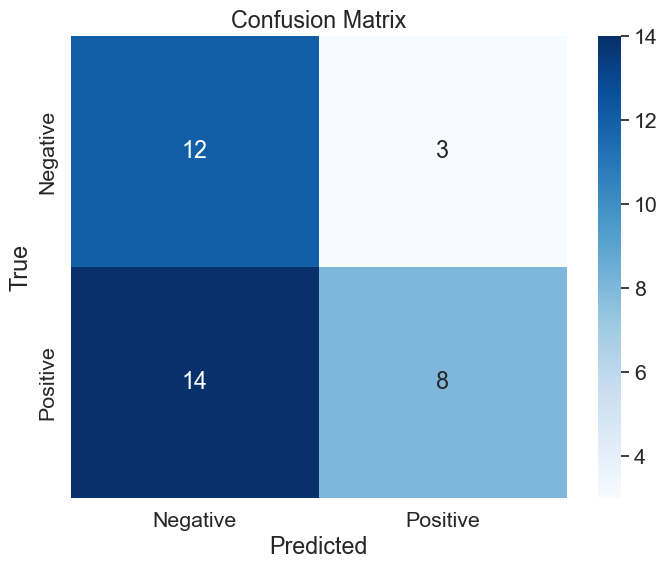

Wrong Buy_Act List:
DOTBRL 

HOTBRL 

SOLBRL 


Pred proft %: 1.0008159163718493
Gamble proft %: 1.0003138467032011
True proft %: 1.0071847325207897

Look Back: 11 / Total Loss: 18003644.750519693 / Sold Portion: 0.625 

['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.40971   ', 'TruePrice: 100.73     ', 'GambleProft: 1.002', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.78775    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.02 ', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['SOLBRL  ', 'LastPrice: 729.1      ', 'MyGamble: 734.00677  ', 'TruePrice: 726.4      ', 'GambleProft: 1.0

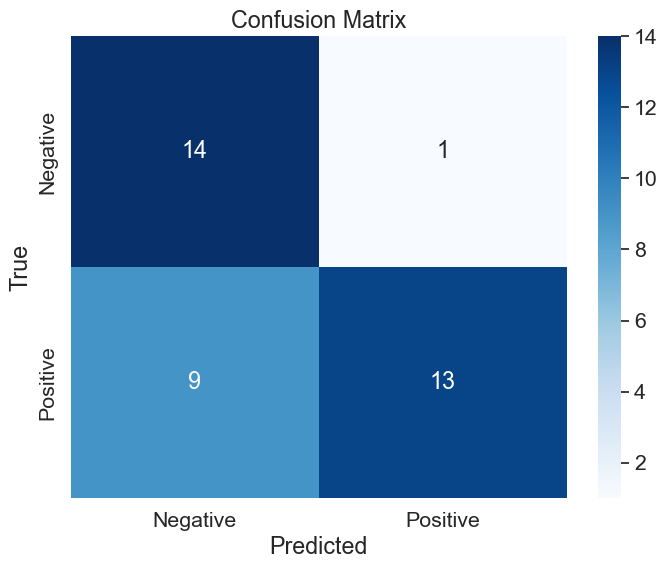

Wrong Buy_Act List:
SOLBRL 



In [28]:
for i in range(10):
    pred_eval(model_3, epochs = 100, lb_list = [11], ticker_list = symbols, print_info = False)


Pred proft %: 1.0112639028033552
Gamble proft %: 1.011263577092823
True proft %: 1.0040670106558292

Look Back: 11 / Total Loss: 16434446.189736957 / Sold Portion: 0.42857142857142855 

['BTCBRL  ', 'LastPrice: 343050.0   ', 'MyGamble: 346913.875 ', 'TruePrice: 344444.0   ', 'GambleProft: 1.011', 'TrueProft: 1.004', 'SoldStatus: 0', 'CorrectModel: 1']
['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.979      ', 'TruePrice: 4.977      ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.45594  ', 'TruePrice: 100.73     ', 'GambleProft: 1.013', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00102    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.02 ', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['HOTBRL  ', 'LastPrice: 0.0394     ', 'MyGamble: 0.04019    ', 'TruePrice: 0.0386     ', 'GambleProft: 1.02 ', 'TrueProft: 0.98 ', 'SoldStat

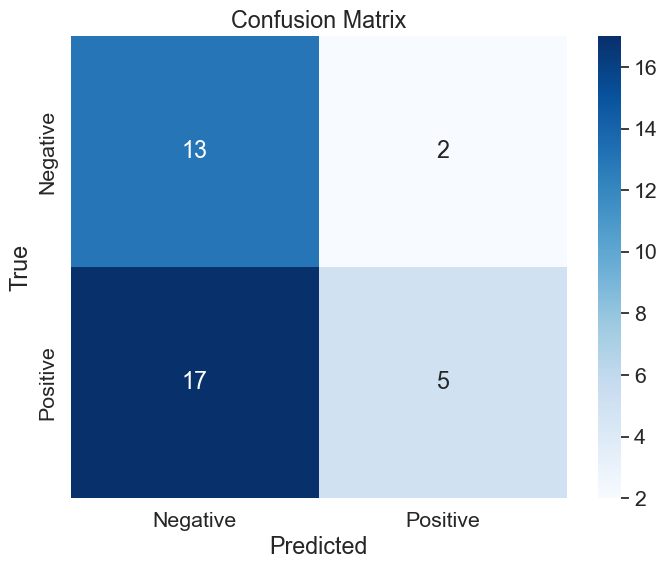

Wrong Buy_Act List:
HOTBRL 

GMTBRL 


Pred proft %: 1.0013624971711053
Gamble proft %: 1.0023430879066482
True proft %: 1.0103493394389877

Look Back: 11 / Total Loss: 8215089.910813871 / Sold Portion: 0.8 

['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.66448    ', 'TruePrice: 3.74       ', 'GambleProft: 1.007', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77438    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.003', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.70483    ', 'TruePrice: 5.827      ', 'GambleProft: 1.007', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.62      ', 'MyGamble: 19.91839   ', 'TruePrice: 19.78      ', 'GambleProft: 1.015', 'TrueProft: 1.008', 'SoldStatus: 0', 'CorrectModel: 1']
['GALABRL ', 'LastPrice: 0.2204     ', 'MyGamble: 0.22099    ', 'TruePrice: 0.2828     ', 'GambleProft: 1.003', 'TrueP

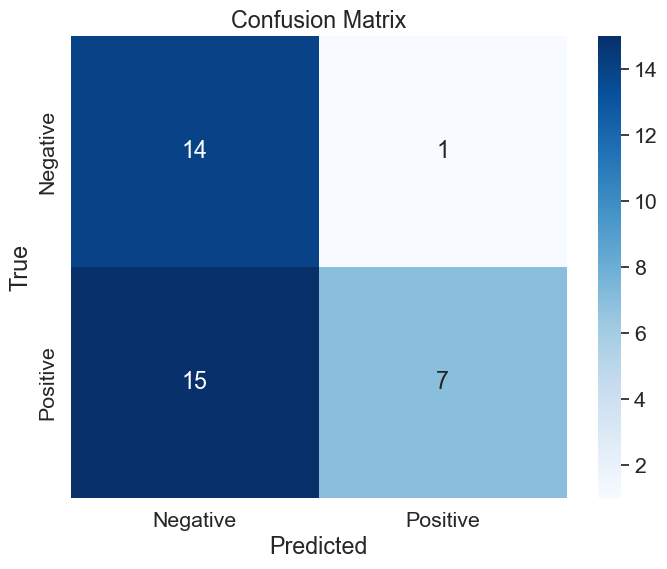

Wrong Buy_Act List:
APTBRL 


Pred proft %: 1.0160959287742317
Gamble proft %: 1.0160480855755198
True proft %: 1.006152132609836

Look Back: 11 / Total Loss: 29092390.24832939 / Sold Portion: 0.75 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2489.02246 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.016', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['DOTBRL  ', 'LastPrice: 53.62      ', 'MyGamble: 53.99285   ', 'TruePrice: 52.91      ', 'GambleProft: 1.007', 'TrueProft: 0.987', 'SoldStatus: 0', 'CorrectModel: 0']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.01429    ', 'TruePrice: 0.01493    ', 'GambleProft: 1.012', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['MATICBRL', 'LastPrice: 5.666      ', 'MyGamble: 5.69507    ', 'TruePrice: 5.827      ', 'GambleProft: 1.005', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 67.57      ', 'MyGamble: 68.56322   ', 'TruePrice: 69.73      ', 'GambleProft: 1.015', 'TrueProft: 1.03

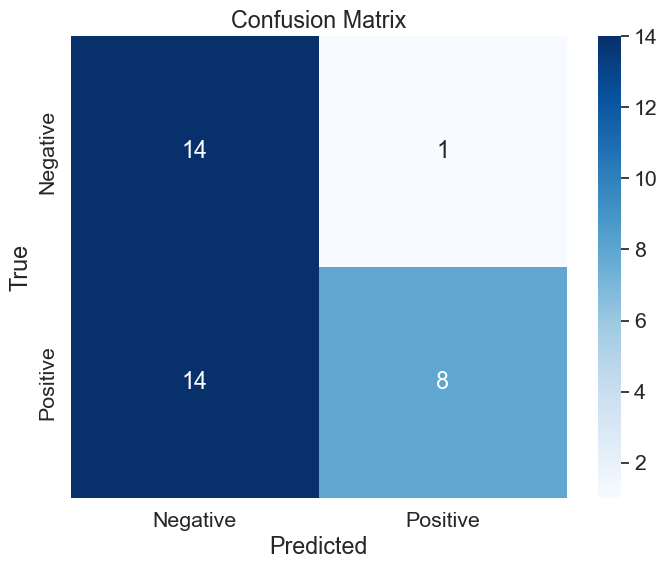

Wrong Buy_Act List:
DOTBRL 


Pred proft %: 1.0055145052876084
Gamble proft %: 1.0055127845481315
True proft %: 1.0072615805883225

Look Back: 11 / Total Loss: 63515006.547769055 / Sold Portion: 0.9090909090909091 

['USDTBRL ', 'LastPrice: 5.036      ', 'MyGamble: 5.04163    ', 'TruePrice: 5.042      ', 'GambleProft: 1.001', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19659.73828', 'TruePrice: 19691.93   ', 'GambleProft: 1.005', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2466.64282 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.007', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['LTCBRL  ', 'LastPrice: 444.2      ', 'MyGamble: 447.4028   ', 'TruePrice: 456.6      ', 'GambleProft: 1.007', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 

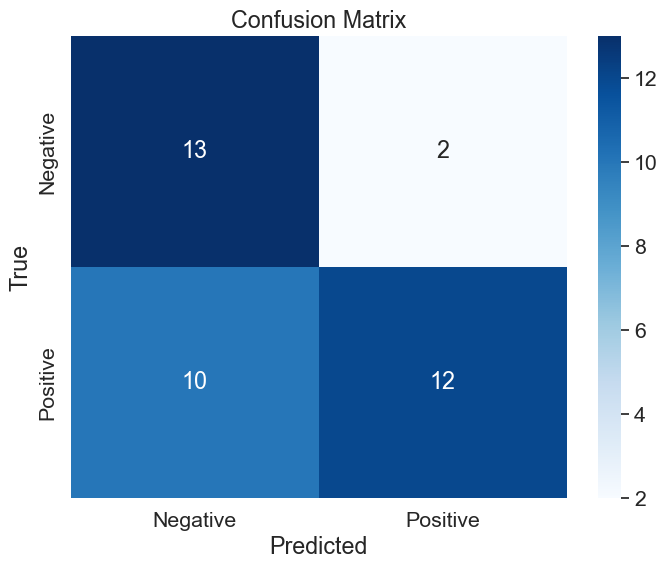

Wrong Buy_Act List:
HOTBRL 

APTBRL 


Pred proft %: 1.0037148500104394
Gamble proft %: 1.0028768533487127
True proft %: 1.0067450899612307

Look Back: 11 / Total Loss: 193920553.79047948 / Sold Portion: 0.75 

['ETHBRL  ', 'LastPrice: 19556.48   ', 'MyGamble: 19606.16718', 'TruePrice: 19691.93   ', 'GambleProft: 1.003', 'TrueProft: 1.007', 'SoldStatus: 1', 'CorrectModel: 1']
['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2463.96167 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.006', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.14277    ', 'TruePrice: 3.125      ', 'GambleProft: 1.007', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.68467    ', 'TruePrice: 3.74       ', 'GambleProft: 1.013', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.78615    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.018', 'True

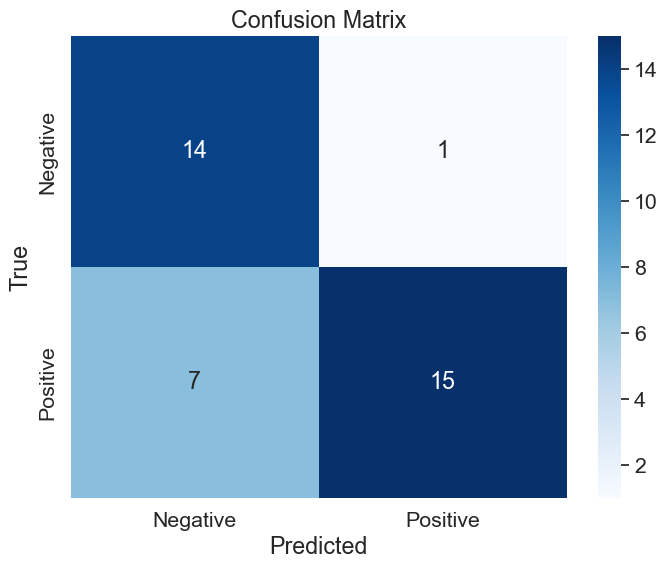

Wrong Buy_Act List:
ETCBRL 


Pred proft %: 1.0316526360075053
Gamble proft %: 1.0306009013506283
True proft %: 1.0169801560928882

Look Back: 11 / Total Loss: 26073917.133969735 / Sold Portion: 0.375 

['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.84517    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.02 ', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.78775    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.02 ', 'TrueProft: 1.011', 'SoldStatus: 0', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00104    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.043', 'TrueProft: 1.006', 'SoldStatus: 0', 'CorrectModel: 1']
['CAKEBRL ', 'LastPrice: 67.57      ', 'MyGamble: 70.05314   ', 'TruePrice: 69.73      ', 'GambleProft: 1.037', 'TrueProft: 1

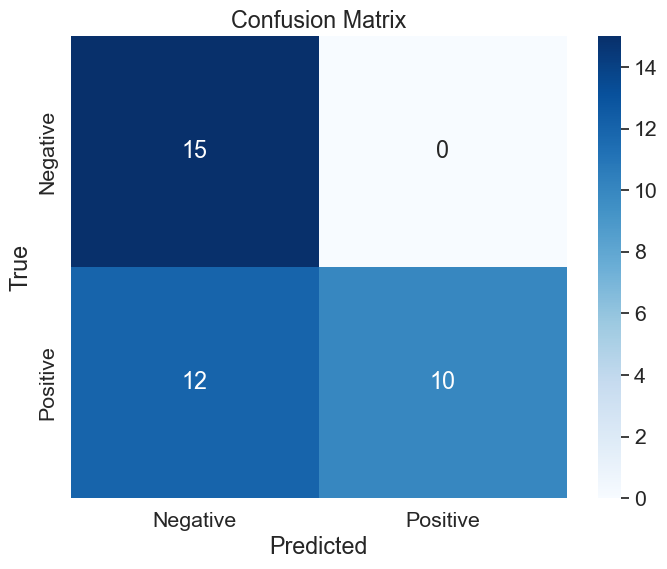


Pred proft %: 1.0095261999366276
Gamble proft %: 1.0091758135269695
True proft %: 1.013274458869609

Look Back: 11 / Total Loss: 14857036.336691083 / Sold Portion: 1.0 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.98189    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.72597  ', 'TruePrice: 100.73     ', 'GambleProft: 1.015', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.83257    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.005', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['AVAXBRL ', 'LastPrice: 214.7      ', 'MyGamble: 216.02509  ', 'TruePrice: 217.2      ', 'GambleProft: 1.006', 'TrueProft: 1.012', 'SoldStatus: 1', 'Correct

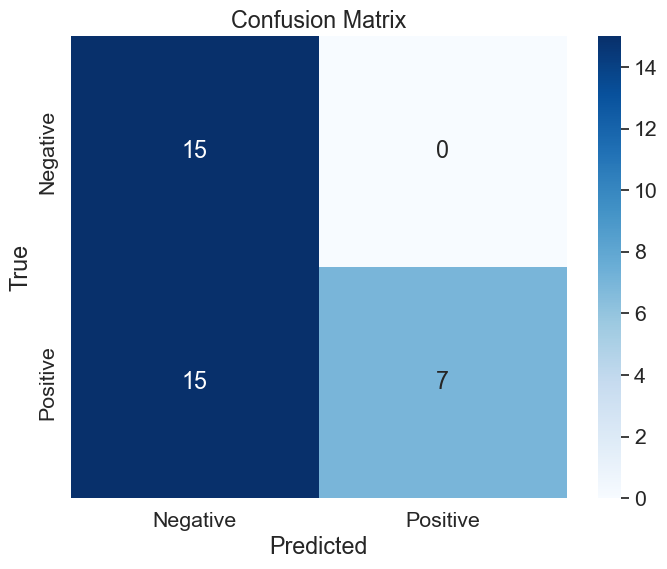


Pred proft %: 0.9975717346222017
Gamble proft %: 1.000027502461587
True proft %: 1.0040897816885006

Look Back: 11 / Total Loss: 5446247.221093206 / Sold Portion: 0.7272727272727273 

['BNBBRL  ', 'LastPrice: 2449.0     ', 'MyGamble: 2451.56812 ', 'TruePrice: 2463.0     ', 'GambleProft: 1.001', 'TrueProft: 1.006', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 99.42535   ', 'TruePrice: 100.73     ', 'GambleProft: 1.002', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['DOGEBRL ', 'LastPrice: 0.8286     ', 'MyGamble: 0.83033    ', 'TruePrice: 0.9016     ', 'GambleProft: 1.002', 'TrueProft: 1.088', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.68202    ', 'TruePrice: 3.74       ', 'GambleProft: 1.012', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.77898    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.009', 'TrueProft: 1.011', 'SoldStatus

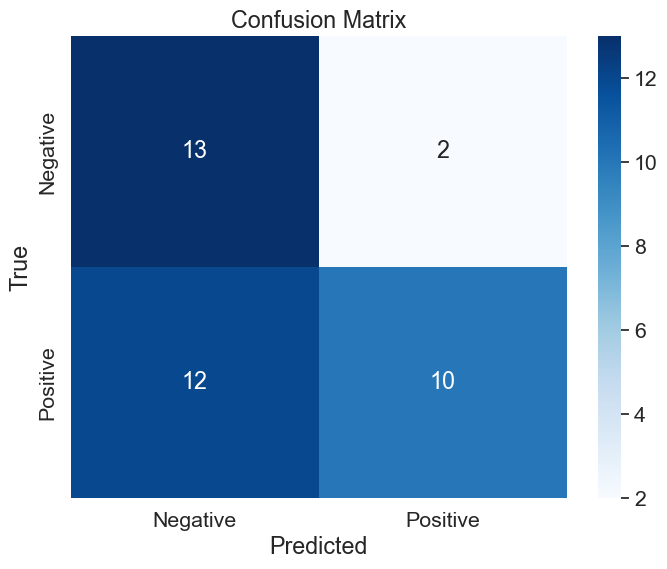

Wrong Buy_Act List:
SHIBBRL 

GMTBRL 


Pred proft %: 1.0032730514558856
Gamble proft %: 1.0033708612292698
True proft %: 1.004414125656451

Look Back: 11 / Total Loss: 41189522.59774154 / Sold Portion: 0.8333333333333334 

['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.19316    ', 'TruePrice: 3.125      ', 'GambleProft: 1.023', 'TrueProft: 1.001', 'SoldStatus: 0', 'CorrectModel: 1']
['CHZBRL  ', 'LastPrice: 0.7723     ', 'MyGamble: 0.78167    ', 'TruePrice: 0.7807     ', 'GambleProft: 1.012', 'TrueProft: 1.011', 'SoldStatus: 1', 'CorrectModel: 1']
['BTTBRL  ', 'LastPrice: 0.01412    ', 'MyGamble: 0.0144     ', 'TruePrice: 0.01493    ', 'GambleProft: 1.02 ', 'TrueProft: 1.057', 'SoldStatus: 1', 'CorrectModel: 1']
['FISBRL  ', 'LastPrice: 1.682      ', 'MyGamble: 1.71564    ', 'TruePrice: 1.794      ', 'GambleProft: 1.02 ', 'TrueProft: 1.067', 'SoldStatus: 1', 'CorrectModel: 1']
['SANTOSBRL', 'LastPrice: 19.62      ', 'MyGamble: 19.76205   ', 'TruePrice: 19.78      ', 'GambleProft:

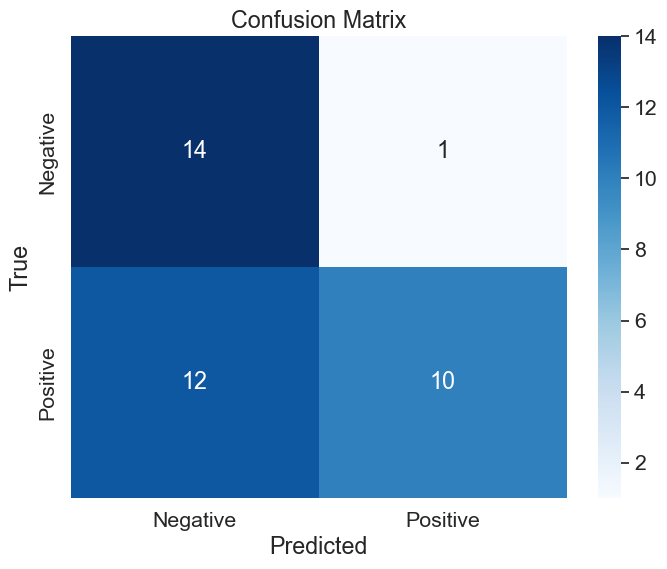

Wrong Buy_Act List:
APTBRL 


Pred proft %: 1.0140523725367003
Gamble proft %: 1.0129190996816149
True proft %: 1.0173299371149673

Look Back: 11 / Total Loss: 8838351.715309232 / Sold Portion: 0.7272727272727273 

['BUSDBRL ', 'LastPrice: 4.973      ', 'MyGamble: 4.98166    ', 'TruePrice: 4.977      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['XRPBRL  ', 'LastPrice: 3.122      ', 'MyGamble: 3.12845    ', 'TruePrice: 3.125      ', 'GambleProft: 1.002', 'TrueProft: 1.001', 'SoldStatus: 1', 'CorrectModel: 1']
['LINKBRL ', 'LastPrice: 99.19      ', 'MyGamble: 100.62537  ', 'TruePrice: 100.73     ', 'GambleProft: 1.014', 'TrueProft: 1.016', 'SoldStatus: 1', 'CorrectModel: 1']
['ADABRL  ', 'LastPrice: 3.638      ', 'MyGamble: 3.66265    ', 'TruePrice: 3.74       ', 'GambleProft: 1.007', 'TrueProft: 1.028', 'SoldStatus: 1', 'CorrectModel: 1']
['WINBRL  ', 'LastPrice: 0.001      ', 'MyGamble: 0.00103    ', 'TruePrice: 0.00101    ', 'GambleProft: 1.029', '

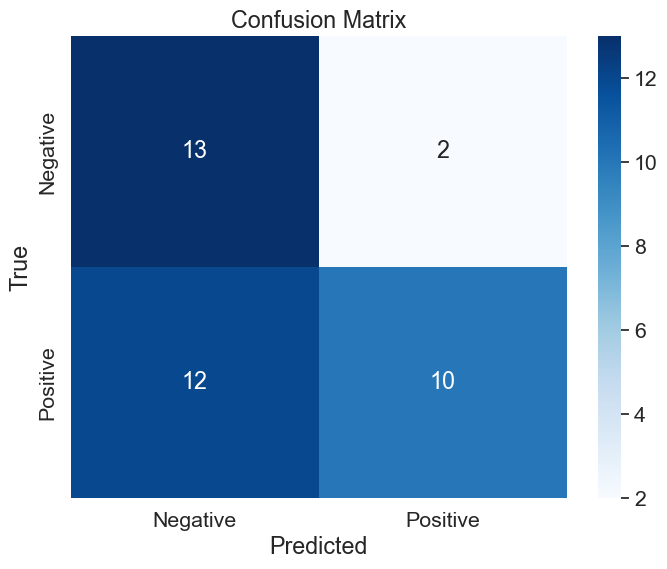

Wrong Buy_Act List:
HOTBRL 

APTBRL 



In [30]:
for i in range(10):
    pred_eval(model_5, epochs = 100, lb_list = [11], ticker_list = symbols, print_info = False)

# Make a dataframe and save results

In [70]:
import threading
import multiprocessing
import os

# Function to execute in threads or processes
def your_function():
    pred_eval(model_1, epochs = 5000, lb_list = [11], ticker_list = symbols[:3])

def run_multithreading():
    num_threads = os.cpu_count()  # Use all available CPU cores
    threads = []
    for _ in range(num_threads):
        thread = threading.Thread(target=your_function)
        thread.start()
        threads.append(thread)
    for thread in threads:
        thread.join()

def run_multiprocessing():
    num_processes = os.cpu_count()  # Use all available CPU cores
    processes = []
    for _ in range(num_processes):
        process = multiprocessing.Process(target=your_function)
        process.start()
        processes.append(process)
    for process in processes:
        process.join()
        
your_function()

KeyboardInterrupt: 

In [ ]:
#csv_file = df.to_csv(f"Prediction_{present_day}.csv",index=False)

In [ ]:
dic = {"Ticker":[],"Act":[],"LastPrice":[],"Pred1":[],"Pred2":[]}
for ticker, status, last_price, pred_1, pred_2 in zip(symbols, pred_status_list, last_price_list, pred_1_list, pred_2_list):
    dic["Ticker"].append(ticker)
    dic["Act"].append(status)
    dic["LastPrice"].append(last_price)
    dic["Pred1"].append(pred_1)
    dic["Pred2"].append(pred_2)
df = pd.DataFrame(dic)
display(df)
display(df.loc[df["Act"]==True])

In [ ]:
pred_status_list, true_status_list = [], []
last_price_list = []
pred_1_list, pred_2_list = [], []
total_last_stock_price, total_pred_stock_price, total_true_stock_price = 0, 0, 0

for ticker in symbols:
    price = database[ticker]
    status, last_price, pred1, pred2, true_price1, true_price2 = predict(price, ticker=ticker)
    pred_status_list.append(status)
    last_price_list.append(last_price)
    pred_1_list.append(pred1)
    pred_2_list.append(pred2)
    pred_proft, true_proft = pred1 - last_price, true_price1 - last_price
    if status:
        total_last_stock_price += last_price
        total_pred_stock_price += pred1
        total_true_stock_price += true_price1
    if true_proft > 0:
        true_status_list.append(True)
    if true_proft <= 0:
        true_status_list.append(False)

print('\nPred proft %:', total_pred_stock_price / total_last_stock_price)
print('\nTrue proft %:', total_true_stock_price / total_last_stock_price)
my_confusion_matrix(true_status_list, pred_status_list)

In [50]:
max_crypto = ''
min_crypto = ''
max_max_value = 0
min_max_value = 1e3
for ticker in symbols:
    price = database[ticker]
    max_value = max(price)
    if max_value > max_max_value:
        max_max_value = max_value
        max_crypto = ticker
    if max_value < min_max_value:
        min_max_value = max_value
        min_crypto = ticker
        
print('MaxCrypto:', max_crypto, max_max_value)
print('MinCrypto:', min_crypto, min_max_value)

MaxCrypto: BTCBRL 376520.0
MinCrypto: SHIBBRL 0.00044702
